In [109]:
import cell_lineage_tracking as lineage
from scipy.spatial.distance import euclidean
import networkx as nx
from multiprocessing import Pool, cpu_count
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
from torch_geometric.data import Data,InMemoryDataset
import torch
import torch.nn as nn
from torch.utils.data import Subset
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np

In [110]:
folder = 'DUMM_giTG69_Glucose_013025'
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{folder}.pkl'
all_cells_pd = pd.read_pickle(all_cells_filename)

In [111]:
#for fov 007 and trench id 295
# manually correcting lineages id from track id
ground_truth_lineage_id_dict_295 = {'7': 'A',
                                '25':'A.1',
                                '46':'A.1',
                                '67':'A.1',
                                '73':'A.1.1',
                                '79':'A.1.1',
                                '97':'A.1.1',
                                '102':'A.1.1',
                                '108':'A.1.1',
                                '115':'A.1.1',
                                '119':'A.1.1',
                                '124':'A.1.1',
                                '130':'A.1.1',
                                '132':'A.1.1',
                                '135':'A.1.1',
                                '140':'A.1.1',
                                '142':'A.1.1',
                                '143':'A.1.1.1',
                                '151':'A.1.1.1',
                                '154':'A.1.1.1',
                                '159':'A.1.1.1',
                                '163':'A.1.1.1',
                                '167':'A.1.1.1',
                                '172':'A.1.1.1',
                                '178':'A.1.1.1',
                                '183':'A.1.1.1',
                                '144':'A.1.1.2',
                                '152':'A.1.1.2',
                                '155':'A.1.1.2',
                                '160':'A.1.1.2',
                                '164':'A.1.1.2',
                                '168':'A.1.1.2',
                                '173':'A.1.1.2',
                                '179':'A.1.1.2',
                                '184':'A.1.1.2',
                                '187':'A.1.1.2',
                                '191':'A.1.1.2',
                                '196':'A.1.1.2',
                                '202':'A.1.1.2',
                                '74':'A.1.2',
                                '80':'A.1.2',
                                '93':'A.1.2',
                                '109':'A.1.2',
                                '120':'A.1.2',
                                '125':'A.1.2',
                                '131':'A.1.2',
                                '133':'A.1.2',
                                '136':'A.1.2',
                                '141':'A.1.2',
                                '145':'A.1.2.1',
                                '150':'A.1.2.1',
                                '156':'A.1.2.1',
                                '161':'A.1.2.1',
                                '169':'A.1.2.1',
                                '174':'A.1.2.1',
                                '180':'A.1.2.1',
                                '188':'A.1.2.1',
                                '192':'A.1.2.1',
                                '197':'A.1.2.1',
                                '203':'A.1.2.1',
                                '208':'A.1.2.1',
                                '213':'A.1.2.1',
                                '146':'A.1.2.2',
                                '162':'A.1.2.2',
                                '165':'A.1.2.2',
                                '170':'A.1.2.2',
                                '175':'A.1.2.2',
                                '181':'A.1.2.2',
                                '193':'A.1.2.2',
                                '198':'A.1.2.2',
                                '204':'A.1.2.2',
                                '209':'A.1.2.2',
                                '216':'A.1.2.2',
                                '222':'A.1.2.2',
                                '74':'A.1.2',
                                '19': 'A.2',
                                '81': 'A.2.1',
                                '88':'A.2.1',
                                '94':'A.2.1',
                                '137':'A.2.1',
                                '147':'A.2.1.1',
                                '166':'A.2.1.1',
                                '176':'A.2.1.1',
                                '182':'A.2.1.1',
                                '189':'A.2.1.1',
                                '194':'A.2.1.1',
                                '199':'A.2.1.1',
                                '205':'A.2.1.1',
                                '210':'A.2.1.1',
                                '217':'A.2.1.1',
                                '223':'A.2.1.1',
                                '229':'A.2.1.1',
                                '234':'A.2.1.1',
                                '148':'A.2.1.2',
                                '157':'A.2.1.2',
                                '177':'A.2.1.2',
                                '195':'A.2.1.2',
                                '206':'A.2.1.2',
                                '211':'A.2.1.2',
                                '214':'A.2.1.2',
                                '218':'A.2.1.2',
                                '224':'A.2.1.2.1',
                                '230':'A.2.1.2.1',
                                '235':'A.2.1.2.1',
                                '240':'A.2.1.2.1',
                                '245':'A.2.1.2.1',
                                '249':'A.2.1.2.1',
                                '225':'A.2.1.2.2',
                                '82': 'A.2.2',
                                '138':'A.2.2.1',
                                '158':'A.2.2.1',
                                '171':'A.2.2.1',
                                '190':'A.2.2.1',
                                '207':'A.2.2.1',
                                '212':'A.2.2.1',
                                '220':'A.2.2.1',
                                '227':'A.2.2.1',
                                '232':'A.2.2.1',
                                '238':'A.2.2.1',
                                '243':'A.2.2.1',
                                '247':'A.2.2.1',
                                '255':'A.2.2.1',
                                '258':'A.2.2.1',
                                '262':'A.2.2.1',
                                '264':'A.2.2.1',
                                '267':'A.2.2.1.1',
                                '268':'A.2.2.1.2',
                                '139':'A.2.2.2',
                                '200': 'A.2.2.2.1',
                                '215': 'A.2.2.2.1',
                                '221': 'A.2.2.2.1',
                                '228': 'A.2.2.2.1',
                                '233': 'A.2.2.2.1',
                                '239': 'A.2.2.2.1',
                                '244': 'A.2.2.2.1',
                                '248': 'A.2.2.2.1',
                                '252': 'A.2.2.2.1',
                                '256': 'A.2.2.2.1',
                                '259': 'A.2.2.2.1',
                                '263': 'A.2.2.2.1',
                                '265': 'A.2.2.2.1',
                                '266': 'A.2.2.2.1',
                                '269': 'A.2.2.2.1',
                                '272': 'A.2.2.2.1',
                                '274': 'A.2.2.2.1',
                                '201': 'A.2.2.2.2',
                                '273': 'A.2.2.2.2',
                                '277': 'A.2.2.2.2',
                                '278': 'A.2.2.2.2.1',
                                '280': 'A.2.2.2.2.1',
                                '281': 'A.2.2.2.2.1',
                                '282': 'A.2.2.2.2.1',
                                '283': 'A.2.2.2.2.1',
                                '284': 'A.2.2.2.2.1',
                                '285': 'A.2.2.2.2.1',
                                '286': 'A.2.2.2.2.1',
                                '287': 'A.2.2.2.2.1.1',
                                '288': 'A.2.2.2.2.1.2',
                                '279': 'A.2.2.2.2.2',
                                '289': 'A.2.2.2.2.1',
                                '291': 'A.2.2.2.2.1',
                                '292': 'A.2.2.2.2.1',
                                '293': 'A.2.2.2.2.1',
                                '294': 'A.2.2.2.2.1',
                                '295': 'A.2.2.2.2.1',
                                '296': 'A.2.2.2.2.1',
                                '297': 'A.2.2.2.2.1',
                                '298': 'A.2.2.2.2.1',
                                '290': 'A.2.2.2.2.2.2',
                                '299': 'A.2.2.2.2.2.2',
                                '300': 'A.2.2.2.2.2.2',
                                '301': 'A.2.2.2.2.2.2',
                                '302': 'A.2.2.2.2.2.2.1',
                                '304': 'A.2.2.2.2.2.2.1',
                                '305': 'A.2.2.2.2.2.2.1',
                                '306': 'A.2.2.2.2.2.2.1',
                                '307': 'A.2.2.2.2.2.2.1',
                                '308': 'A.2.2.2.2.2.2.1',
                                '309': 'A.2.2.2.2.2.2.1',
                                '303': 'A.2.2.2.2.2.2.2',
                                '310': 'A.2.2.2.2.2.2.2',
                                '311': 'A.2.2.2.2.2.2.2',
                                '312': 'A.2.2.2.2.2.2.2',
                                '313': 'A.2.2.2.2.2.2.2.1',
                                '315': 'A.2.2.2.2.2.2.2.1',
                                '316': 'A.2.2.2.2.2.2.2.1',
                                '317': 'A.2.2.2.2.2.2.2.1',
                                '318': 'A.2.2.2.2.2.2.2.1',
                                '319': 'A.2.2.2.2.2.2.2.1',
                                '320': 'A.2.2.2.2.2.2.2.1',
                                '314': 'A.2.2.2.2.2.2.2.2',
                                '321': 'A.2.2.2.2.2.2.2.2',
                                '322': 'A.2.2.2.2.2.2.2.2',
                                '323': 'A.2.2.2.2.2.2.2.2',
                                '324': 'A.2.2.2.2.2.2.2.2',
                                '325': 'A.2.2.2.2.2.2.2.2',
                                '326': 'A.2.2.2.2.2.2.2.2',
                                '327': 'A.2.2.2.2.2.2.2.2.1',
                                '329': 'A.2.2.2.2.2.2.2.2.1',
                                '330': 'A.2.2.2.2.2.2.2.2.1',
                                '328': 'A.2.2.2.2.2.2.2.2.2',
                                '331': 'A.2.2.2.2.2.2.2.2.2',
                                '332': 'A.2.2.2.2.2.2.2.2.2.1',
                                '333': 'A.2.2.2.2.2.2.2.2.2.2'}

In [112]:
#for fov 007 and trench id 371
# manually correcting lineages id from track id
ground_truth_lineage_id_dict_371 = {'11': 'A',
                                '12': 'A',
                                '13': 'A',
                                '14':'A.1',
                                '17':'A.1',
                                '20':'A.1',
                                '22':'A.1',
                                '24':'A.1',
                                '27':'A.1',
                                '30':'A.1.1',
                                '33':'A.1.1',
                                '36':'A.1.1',
                                '38':'A.1.1',
                                '15':'A.2',
                                '18':'A.2',
                                '21':'A.2',
                                '23':'A.2',
                                '25':'A.2.1',
                                '28':'A.2.1',
                                '35':'A.2.1',
                                '40':'A.2.1',
                                '26':'A.2.2',
                                '29':'A.2.2',
                                '41':'A.2.2.1',
                                '43':'A.2.2.1',
                                '45':'A.2.2.1',
                                '46':'A.2.2.1.1',
                                '48':'A.2.2.1.1',
                                '50':'A.2.2.1.1',
                                '53':'A.2.2.1.1',
                                '47':'A.2.2.1.2',
                                '49':'A.2.2.1.2',
                                '51':'A.2.2.1.2',
                                '54':'A.2.2.1.2',
                                '55':'A.2.2.1.2',
                                '58':'A.2.2.1.2',
                                '61':'A.2.2.1.2',
                                '64':'A.2.2.1.2',
                                '66':'A.2.2.1.2',
                                '67':'A.2.2.1.2',
                                '69':'A.2.2.1.2',
                                '42':'A.2.2.2',
                                '44':'A.2.2.2',
                                '52':'A.2.2.2',
                                '56':'A.2.2.2.1',
                                '62':'A.2.2.2.1',
                                '65':'A.2.2.2.1',
                                '70':'A.2.2.2.1',
                                '74':'A.2.2.2.1',
                                '57':'A.2.2.2.2',
                                '63':'A.2.2.2.2',
                                '71':'A.2.2.2.2',
                                '74':'A.2.2.2.1',
                                '76':'A.2.2.2.1.1',
                                '80':'A.2.2.2.1.1',
                                '86':'A.2.2.2.1.1',
                                '94':'A.2.2.2.1.1',
                                '97':'A.2.2.2.1.1',
                                '104':'A.2.2.2.1.1',
                                '77':'A.2.2.2.1.2',
                                '81':'A.2.2.2.1.2',
                                '87':'A.2.2.2.1.2',
                                '95':'A.2.2.2.1.2',
                                '98':'A.2.2.2.1.2',
                                '105':'A.2.2.2.1.2',
                                '106':'A.2.2.2.1.2',
                                '108':'A.2.2.2.1.2', 
                                '72':'A.2.2.1.2.1',
                                '78':'A.2.2.1.2.1',
                                '73':'A.2.2.1.2.2',
                                '79':'A.2.2.1.2.2',
                                '85':'A.2.2.1.2.2',
                                '89':'A.2.2.1.2.2',
                                '90':'A.2.2.1.2.2',
                                '101':'A.2.2.1.2.2',
                                '104':'A.2.2.1.2.2',
                                '82':'A.2.2.2.2.1',
                                '88':'A.2.2.2.2.1',
                                '107':'A.2.2.2.2.1',
                                '109':'A.2.2.2.2.1.1',
                                '114':'A.2.2.2.2.1.1',
                                '118':'A.2.2.2.2.1.1',
                                '121':'A.2.2.2.2.1.1',
                                '123':'A.2.2.2.2.1.1',
                                '124':'A.2.2.2.2.1.1',
                                '127':'A.2.2.2.2.1.1',
                                '129':'A.2.2.2.2.1.1',
                                '133':'A.2.2.2.2.1.1',
                                '135':'A.2.2.2.2.1.1',
                                '138':'A.2.2.2.2.1.1',
                                '144':'A.2.2.2.2.1.1.2',
                                '156':'A.2.2.2.2.1.1.2',
                                '162':'A.2.2.2.2.1.1.2',
                                '168':'A.2.2.2.2.1.1.2',
                                '172':'A.2.2.2.2.1.1.2',
                                '177':'A.2.2.2.2.1.1.2',
                                '182':'A.2.2.2.2.1.1.2',
                                '188':'A.2.2.2.2.1.1.2',
                                '196':'A.2.2.2.2.1.1.2',
                                '143':'A.2.2.2.2.1.1.1',
                                '150':'A.2.2.2.2.1.1.1',
                                '155':'A.2.2.2.2.1.1.1',
                                '161':'A.2.2.2.2.1.1.1',
                                '167':'A.2.2.2.2.1.1.1',
                                '170':'A.2.2.2.2.1.1.1.1',
                                '171':'A.2.2.2.2.1.1.1.2',
                                '110':'A.2.2.2.2.1.2',
                                '115':'A.2.2.2.2.1.2',
                                '130':'A.2.2.2.2.1.2',
                                '134':'A.2.2.2.2.1.2',
                                '136':'A.2.2.2.2.1.2',
                                '140':'A.2.2.2.2.1.2.2',
                                '152':'A.2.2.2.2.1.2.2',
                                '158':'A.2.2.2.2.1.2.2',
                                '164':'A.2.2.2.2.1.2.2',
                                '174':'A.2.2.2.2.1.2.2',
                                '179':'A.2.2.2.2.1.2.2',
                                '184':'A.2.2.2.2.1.2.2',
                                '190':'A.2.2.2.2.1.2.2',
                                '198':'A.2.2.2.2.1.2.2',
                                '204':'A.2.2.2.2.1.2.2',
                                '209':'A.2.2.2.2.1.2.2',
                                '213':'A.2.2.2.2.1.2.2',
                                '217':'A.2.2.2.2.1.2.2',
                                '223':'A.2.2.2.2.1.2.2.1',
                                '224':'A.2.2.2.2.1.2.2.2',
                                '139':'A.2.2.2.2.1.2.1',
                                '151':'A.2.2.2.2.1.2.1',
                                '157':'A.2.2.2.2.1.2.1',
                                '163':'A.2.2.2.2.1.2.1',
                                '169':'A.2.2.2.2.1.2.1',
                                '173':'A.2.2.2.2.1.2.1',
                                '178':'A.2.2.2.2.1.2.1',
                                '183':'A.2.2.2.2.1.2.1',
                                '189':'A.2.2.2.2.1.2.1',
                                '197':'A.2.2.2.2.1.2.1',
                                '203':'A.2.2.2.2.1.2.1',
                                '208':'A.2.2.2.2.1.2.1',
                                '212':'A.2.2.2.2.1.2.1',
                                '83':'A.2.2.2.2.2',
                                '91':'A.2.2.2.2.2',
                                '111':'A.2.2.2.2.2.1',
                                '116':'A.2.2.2.2.2.1',
                                '146':'A.2.2.2.2.2.1.1',
                                '165':'A.2.2.2.2.2.1.1',
                                '175':'A.2.2.2.2.2.1.1',
                                '185':'A.2.2.2.2.2.1.1',
                                '191':'A.2.2.2.2.2.1.1',
                                '199':'A.2.2.2.2.2.1.1',
                                '205':'A.2.2.2.2.2.1.1',
                                '210':'A.2.2.2.2.2.1.1',
                                '214':'A.2.2.2.2.2.1.1',
                                '218':'A.2.2.2.2.2.1.1',
                                '225':'A.2.2.2.2.2.1.1',
                                '230':'A.2.2.2.2.2.1.1.1',
                                '231':'A.2.2.2.2.2.1.1.2',
                                '112':'A.2.2.2.2.2.2',
                                '117':'A.2.2.2.2.2.2',
                                '122':'A.2.2.2.2.2.2',
                                '128':'A.2.2.2.2.2.2',
                                '137':'A.2.2.2.2.2.2'}
for key, value in ground_truth_lineage_id_dict_371.items():
    ground_truth_lineage_id_dict_371[key] = value.replace('A', 'G')



FOV = '007'
trench_id = ['295', '371']
df = all_cells_pd[(all_cells_pd['FOV'] == FOV) & all_cells_pd['trench_id'].isin(trench_id)].copy()
df['track_id'] = df['track_id'].astype(np.int64)
df['track_id'] = df['track_id'].astype(str)

df.loc[:, 'ground_truth_lineage'] = None
df.loc[df['trench_id'] =='295', 'ground_truth_lineage']= df.loc[df['trench_id'] =='295','track_id'].map(ground_truth_lineage_id_dict_295)
df.loc[df['trench_id'] =='371', 'ground_truth_lineage']= df.loc[df['trench_id'] =='371','track_id'].map(ground_truth_lineage_id_dict_371)

df.rename(columns = {'centroid-0': 'centroid_y','centroid-1': 'centroid_x'}, inplace = True)
df_cells = df[df['ground_truth_lineage'].notna()]
# Define node features
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']

for col in node_feature_cols:
    df_cells.loc[:, col] = df_cells.loc[:,col].astype(np.float32);               
# Convert lineage IDs to unique integers as labels
all_unique_lineages = sorted(df_cells['ground_truth_lineage'].unique())
lineage_to_int_mapping = {lineage: i for i, lineage in enumerate(all_unique_lineages)}
num_lineage_classes = len(all_unique_lineages)
df_cells.loc[:, 'numeric_lineage'] = df_cells.loc[:, 'ground_truth_lineage'].map(lineage_to_int_mapping)
df_cells.loc[:,'node_id'] = df_cells.index # Assign unique global node ID

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_87414/1977804031.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells.loc[:, 'numeric_lineage'] = df_cells.loc[:, 'ground_truth_lineage'].map(lineage_to_int_mapping)
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_87414/1977804031.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells.loc[:,'node_id'] = df_cells.index # Assign unique global node ID


In [113]:
def create_time_step_data_objects(df_lineage: pd.DataFrame, node_feature_cols: list, device='cpu'):
    """
    Generates a list of Data objects, where each Data object represents a single
    time-step transition (t -> t+1) within a lineage branch.

    Args:
        df_lineage (pd.DataFrame): DataFrame containing data for a specific lineage branch.
        node_feature_cols (list): List of column names for node features.
        device (str): Device to put tensors on.

    Returns:
        list[Data]: A list of PyG Data objects, each representing one t -> t+1 transition.
    """
    all_time_step_data = []

    # Get unique time frames and sort them
    sorted_time_frames = sorted(df_lineage['time_frame'].unique())

    # Iterate through consecutive time frames
    for i in range(len(sorted_time_frames) - 1):
        current_t = sorted_time_frames[i]
        next_t = sorted_time_frames[i+1]

        df_current_t = df_lineage[df_lineage['time_frame'] == current_t].copy() # .copy() to avoid SettingWithCopyWarning
        df_next_t = df_lineage[df_lineage['time_frame'] == next_t].copy()

        # Skip if no cells in either timeframe (unlikely for a valid lineage, but good check)
        if df_current_t.empty or df_next_t.empty:
            continue

        # Create combined node features, positions, time_frames for this specific t -> t+1 pair
        # Ensure consistent order. Nodes from current_t come first, then nodes from next_t.
        x_t = torch.tensor(df_current_t[node_feature_cols].values, dtype=torch.float).to(device)
        x_t_plus_1 = torch.tensor(df_next_t[node_feature_cols].values, dtype=torch.float).to(device)
        x = torch.cat([x_t, x_t_plus_1], dim=0)

        pos_t = torch.tensor(df_current_t['centroid_y'].values, dtype=torch.float).to(device) # Assuming centroid_y is your 'pos'
        pos_t_plus_1 = torch.tensor(df_next_t['centroid_y'].values, dtype=torch.float).to(device)
        pos = torch.cat([pos_t, pos_t_plus_1], dim=0)

        time_frames_t = torch.tensor(df_current_t['time_frame'].values, dtype=torch.long).to(device)
        time_frames_t_plus_1 = torch.tensor(df_next_t['time_frame'].values, dtype=torch.long).to(device)
        time_frame_concat = torch.cat([time_frames_t, time_frames_t_plus_1], dim=0)


        # Map global node IDs to local indices *within this specific t -> t+1 Data object*
        # Cells from df_current_t get indices 0 to num_cells_t - 1
        # Cells from df_next_t get indices num_cells_t to num_cells_t + num_cells_t_plus_1 - 1
        num_cells_t = len(df_current_t)
        num_cells_t_plus_1 = len(df_next_t)
        offset_t_plus_1_nodes = num_cells_t

        local_id_map = {}
        for idx, row in df_current_t.reset_index().iterrows():
            local_id_map[row['node_id']] = idx # Local index for current_t cells
        for idx, row in df_next_t.reset_index().iterrows():
            local_id_map[row['node_id']] = idx + offset_t_plus_1_nodes # Local index for next_t cells

        # Find the single true positive edge(s) for this time step
        # (Handling mitosis, so there might be one parent -> one daughter OR one parent -> two daughters)
        true_source_local_idx = []
        true_target_local_idx = []

        # Convert lineage IDs to node IDs for faster lookup
        current_lineage_to_node_id = df_current_t.set_index('ground_truth_lineage')['node_id'].to_dict()
        next_node_id_to_lineage = df_next_t.set_index('node_id')['ground_truth_lineage'].to_dict()

        for _, row_t in df_current_t.iterrows():
            parent_gt_lineage = row_t['ground_truth_lineage']
            parent_node_id = row_t['node_id']
            parent_local_idx = local_id_map[parent_node_id]

            # Check for direct continuation (A -> A)
            if parent_gt_lineage in next_node_id_to_lineage.values():
                # Find the node_id in df_next_t that has this lineage
                next_global_node_id = df_next_t[df_next_t['ground_truth_lineage'] == parent_gt_lineage]['node_id'].iloc[0]
                true_source_local_idx.append(parent_local_idx)
                true_target_local_idx.append(local_id_map[next_global_node_id])

            # Check for mitotic division (A -> A.1, A -> A.2)
            daughter1_lineage = f"{parent_gt_lineage}.1"
            daughter2_lineage = f"{parent_gt_lineage}.2"

            if daughter1_lineage in next_node_id_to_lineage.values():
                next_global_node_id = df_next_t[df_next_t['ground_truth_lineage'] == daughter1_lineage]['node_id'].iloc[0]
                true_source_local_idx.append(parent_local_idx)
                true_target_local_idx.append(local_id_map[next_global_node_id])

            if daughter2_lineage in next_node_id_to_lineage.values():
                next_global_node_id = df_next_t[df_next_t['ground_truth_lineage'] == daughter2_lineage]['node_id'].iloc[0]
                true_source_local_idx.append(parent_local_idx)
                true_target_local_idx.append(local_id_map[next_global_node_id])

        if not true_source_local_idx:
            # This can happen if a lineage dies out or ends.
            # For link prediction training, we might still want to create a Data object
            # if we plan to train on "no link" scenarios.
            # However, for HNM, we need at least one positive edge for the current strategy.
            # So, we'll skip creating a Data object if no true positive links exist.
            continue
            # If you wanted to include these as "all negatives" examples, you'd create
            # an empty edge_index and handle it in the training loop.
            # For now, we'll assume each training batch must have a true positive.


        # Create the edge_index for the true positive link(s) for this timeframe
        # This will be `data.edge_index` in the new Data object.
        true_pos_edges_for_this_timeframe = torch.tensor([
            true_source_local_idx,
            true_target_local_idx
        ], dtype=torch.long).to(device)


        # Create and append the Data object for this time step
        data = Data(
            x=x,
            edge_index=true_pos_edges_for_this_timeframe, # This now contains only the true positive link(s) for this t -> t+1
            pos=pos, # All positions for cells in this timeframe
            time_frame=time_frame_concat, # All time frames for cells in this timeframe (t then t+1)
            num_nodes=len(x), # Total nodes in this specific Data object
            # New attributes required for HNM
            num_nodes_t=num_cells_t,
            num_nodes_t_plus_1=num_cells_t_plus_1,
            offset_t_plus_1_nodes=offset_t_plus_1_nodes,
            # Pass original global IDs for debugging/tracking, but locally mapped
            original_global_node_ids_t=torch.tensor(df_current_t['node_id'].values, dtype=torch.long),
            original_global_node_ids_t_plus_1=torch.tensor(df_next_t['node_id'].values, dtype=torch.long),
            # Keep original metadata if useful for grouping/filtering later
            experiment_name=df_lineage['experiment_name'].iloc[0],
            fov=df_lineage['FOV'].iloc[0],
            trench_id=df_lineage['trench_id'].iloc[0],
            # If you still need lineage label 'y' for something, you'd need to adapt.
            # For link prediction, `y` is usually the link label (1 for positive, 0 for negative),
            # which we are now generating dynamically. So, `y` might not be directly used here.
            # If 'numeric_lineage' is still a node property for the GNN input, keep it in `x` or separately.
        )
        all_time_step_data.append(data)

    return all_time_step_data

In [114]:
def train_one_epoch_cell_tracking_hnm(model, loader, optimizer, criterion, device, radius_threshold: float, num_hard_neg_per_positive=None):
    model.train()
    total_loss = 0
    num_batches = 0

    for i, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()

        if data.edge_index.numel() == 0:
            print(f"Skipping training batch {i+1}: No positive edges for this timeframe.")
            continue

        if data.edge_index.dtype != torch.long: data.edge_index = data.edge_index.long()

        # Compute node embeddings
        z = model(data.x, data.edge_index) # Or model.encode(data.x) if your GNN is set up that way

        # --- HNM Specific Steps ---
        # 1. Generate ALL plausible negative candidates using your adapted function
        candidate_neg_edge_index = get_all_plausible_negative_candidates(
            data,
            radius_threshold=radius_threshold, # Pass your radius_threshold here
            device=device
        )

        # Handle cases where no negative candidates are left after filtering (very rare if your data is structured)
        if candidate_neg_edge_index.numel() == 0:
            print(f"Warning (Batch {i+1}): No plausible negative candidates generated for this timeframe. Training with positive only.")
            logits = model.decode(z, data.edge_index)
            labels = torch.ones(logits.size(0), device=device)
        else:
            # 2. Compute logits for positive and ALL candidate negative samples
            pos_logits = model.decode(z, data.edge_index)
            candidate_neg_logits = model.decode(z, candidate_neg_edge_index)

            # 3. Identify Hard Negatives (select top N highest logits from candidates)
            sorted_neg_logits, _ = torch.sort(candidate_neg_logits, descending=True)

            if num_hard_neg_per_positive is None:
                # Default: take a fixed number of hardest negatives, up to the total available
                num_hard_neg_to_select = min(5, sorted_neg_logits.numel()) # Example: Top 5 hardest negatives
            else:
                # Use the ratio: ensures at least one positive is matched with ratio_val hard negatives
                num_hard_neg_to_select = min(int(num_hard_neg_per_positive * pos_logits.size(0)), sorted_neg_logits.numel())

            if num_hard_neg_to_select == 0:
                print(f"Warning (Batch {i+1}): No hard negative samples selected based on criteria. Training with positive only.")
                selected_hard_neg_logits = torch.empty(0, device=device)
            else:
                selected_hard_neg_logits = sorted_neg_logits[:num_hard_neg_to_select]

            # 4. Construct final batch logits and labels
            logits = torch.cat([pos_logits, selected_hard_neg_logits])
            labels = torch.cat([
                torch.ones(pos_logits.size(0), device=device),
                torch.zeros(selected_hard_neg_logits.size(0), device=device)
            ])

        # 5. Calculate loss and backpropagate
        if logits.numel() == 0:
            print(f"Skipping batch {i+1}: Final logits tensor is empty after HNM. (This should be rare if pos_edge_index exists).")
            continue

        loss = criterion(logits.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return avg_loss

In [115]:
import torch
import numpy as np
from torch_geometric.data import Data, Batch

In [116]:
def get_all_plausible_negative_candidates(data: Batch, radius_threshold: float,
                                          device='cpu', num_neg_samples_per_pos_edge: int = None,
                                          positive_edges_to_exclude: torch.Tensor = None):
    """
    Generates plausible negative samples by considering only cells in consecutive time frames
    and within a certain spatial radius of potential source nodes, excluding true positives.
    This function processes a torch_geometric.data.Batch object.

    Args:
        data (torch_geometric.data.Batch): A batch of graphs containing x, edge_index, pos, time_frame,
                                          and critically, data.ptr for graph separation.
        radius_threshold (float): Maximum spatial distance for a potential negative connection.
        device (str): Device to put tensors on.
        num_neg_samples_per_pos_edge (int, optional): If provided, samples a fixed ratio of negatives
                                                     per positive edge from the plausible pool.
                                                     If None, returns all plausible negatives.
        positive_edges_to_exclude (torch.Tensor, optional): A tensor of known positive edges (batch-local indices)
                                                          to explicitly exclude from the negative samples.
                                                          If None, data.edge_index will be used.

    Returns:
        torch.Tensor: edge_index of plausible negative connections, shape [2, num_plausible_neg_samples].
    """
    all_plausible_neg_samples_batch_local = []

    # Ensure positive_edges_to_exclude is set, typically data.edge_index from the current batch
    if positive_edges_to_exclude is None:
        positive_edges_to_exclude = data.edge_index.cpu()
    else:
        positive_edges_to_exclude = positive_edges_to_exclude.cpu() # Ensure on CPU for set conversion

    existing_edges_overall_batch = set(tuple(e) for e in positive_edges_to_exclude.T.tolist())

    # Iterate through each graph within the batch
    num_graphs_in_batch = len(data.ptr) - 1

    for graph_idx_in_batch in range(num_graphs_in_batch):
        start_node_idx_in_batch = data.ptr[graph_idx_in_batch].item()
        end_node_idx_in_batch = data.ptr[graph_idx_in_batch + 1].item()

        # Get the nodes (and their attributes) belonging to this specific graph in the batch
        graph_node_indices_batch_local = torch.arange(start_node_idx_in_batch, end_node_idx_in_batch, device=device)
        
        # Slice relevant attributes for the current graph from the concatenated batch tensors
        graph_pos_coords = data.pos[graph_node_indices_batch_local].cpu().numpy()
        graph_time_frames = data.time_frame[graph_node_indices_batch_local].cpu().numpy()
        graph_num_nodes = len(graph_node_indices_batch_local)

        # Skip if not enough nodes in this graph to form pairs
        if graph_num_nodes < 2:
            continue

        plausible_neg_samples_current_graph_local = []

        for i_local in range(graph_num_nodes): # Source node in *local* graph indices
            current_node_time = graph_time_frames[i_local]
            current_node_pos = graph_pos_coords[i_local]
            
            # Map local index back to batch-global index for checking existing_edges
            i_batch_global = start_node_idx_in_batch + i_local

            for j_local in range(graph_num_nodes): # Target node in *local* graph indices
                # Map local index back to batch-global index
                j_batch_global = start_node_idx_in_batch + j_local

                # 1. Temporal Constraint
                if graph_time_frames[j_local] != current_node_time + 1:
                    continue

                # 2. Local Constraint (Spatial Proximity)
                target_node_pos = graph_pos_coords[j_local]
                # Handle 1D or multi-D pos
                if graph_pos_coords.ndim == 1:
                    distance = np.abs(current_node_pos - target_node_pos)
                else: # Assuming 2D or 3D for spatial coordinates
                    distance = np.linalg.norm(current_node_pos - target_node_pos)

                if distance > radius_threshold:
                    continue

                # 3. Exclude existing positive edges (using batch-global indices)
                if (i_batch_global, j_batch_global) not in existing_edges_overall_batch:
                    plausible_neg_samples_current_graph_local.append((i_batch_global, j_batch_global))

        # Optionally sample from the plausible pool if num_neg_samples_per_pos_edge is provided
        if num_neg_samples_per_pos_edge is not None and len(plausible_neg_samples_current_graph_local) > 0:
            num_pos_edges_current_graph = 0
            
            graph_pos_edges_count = 0
            for src_b, tgt_b in existing_edges_overall_batch:
                if start_node_idx_in_batch <= src_b < end_node_idx_in_batch and \
                   start_node_idx_in_batch <= tgt_b < end_node_idx_in_batch:
                   graph_pos_edges_count += 1

            target_num_neg_samples = int(graph_pos_edges_count * num_neg_samples_per_pos_edge)
            
            if target_num_neg_samples > 0 and len(plausible_neg_samples_current_graph_local) > target_num_neg_samples:
                # Randomly sample from the plausible pool
                indices = np.random.choice(len(plausible_neg_samples_current_graph_local), target_num_neg_samples, replace=False)
                sampled_negatives = [plausible_neg_samples_current_graph_local[k] for k in indices]
                all_plausible_neg_samples_batch_local.extend(sampled_negatives)
            else:
                all_plausible_neg_samples_batch_local.extend(plausible_neg_samples_current_graph_local)
        else:
            all_plausible_neg_samples_batch_local.extend(plausible_neg_samples_current_graph_local)


    if not all_plausible_neg_samples_batch_local:
        return torch.empty((2, 0), dtype=torch.long, device=device)

    return torch.tensor(all_plausible_neg_samples_batch_local, dtype=torch.long).T.to(device)

In [117]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
import numpy as np
import torch_geometric.utils
import pandas as pd

In [118]:
def evaluate_link_prediction(model, loader, criterion, device,
                             neg_sample_ratio=1.0, # This will be passed as num_neg_samples_per_pos_edge
                             radius_threshold=None, epoch_num=None): 
    model.eval()
    total_loss = 0
    all_logits_agg = []
    all_labels_agg = []
    all_predicted_positive_global_edges = [] # Store (src_global_id, tgt_global_id, is_t_plus_1, prob, label)

    num_batches_processed_eval = 0

    print(f"\n--- Starting Evaluation for Epoch {epoch_num if epoch_num is not None else 'N/A'} (Batch-by-Batch) ---")

    # --- First pass: Calculate metrics and store logits/labels ---
    with torch.no_grad():
        current_combined_edge_idx_first_pass = 0 # To track index in aggregated logits/labels

        for i, data in enumerate(loader):
            data = data.to(device)

            # Essential attributes check
            required_attrs = ['original_global_node_ids_t', 'original_global_node_ids_t_plus_1',
                              'num_nodes_t', 'num_nodes_t_plus_1', 'offset_t_plus_1_nodes', 'ptr',
                              'pos', 'time_frame'] # Added pos, time_frame for negative sampling func
            if not all(hasattr(data, attr) for attr in required_attrs):
                print(f"  Skipping batch {i+1} due to missing essential attributes: {', '.join([attr for attr in required_attrs if not hasattr(data, attr)])}")
                # We need to correctly advance current_combined_edge_idx even if skipping
                # Estimate how many edges this batch would have if it was valid
                predicted_num_edges = data.edge_index.size(1) if hasattr(data, 'edge_index') else 0
                predicted_num_edges += predicted_num_edges * neg_sample_ratio # Estimate negative edges
                current_combined_edge_idx_first_pass += int(predicted_num_edges)
                continue


            if data.edge_index.dtype != torch.long:
                data.edge_index = data.edge_index.long()

            # --- Negative Sampling Logic (Using get_all_plausible_negative_candidates) ---
            
            # data.edge_index contains true positive edges for this batch
            current_positive_edges_for_exclusion = data.edge_index 

            neg_edge_index = get_all_plausible_negative_candidates(
                data,
                radius_threshold=radius_threshold,
                device=device,
                num_neg_samples_per_pos_edge=neg_sample_ratio,
                positive_edges_to_exclude=current_positive_edges_for_exclusion # Pass the batch-local positive edges
            )

            # Ensure neg_edge_index is a 2x0 tensor if empty, for proper concatenation
            if neg_edge_index is None or neg_edge_index.numel() == 0:
                neg_edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
            else:
                if neg_edge_index.dtype != torch.long:
                    neg_edge_index = neg_edge_index.long()
                neg_edge_index = neg_edge_index.to(device)


            # --- Model Forward Pass ---
            z = model(data.x, data.edge_index) # Node embeddings
            pos_logits = model.decode(z, data.edge_index)

            if neg_edge_index.numel() > 0:
                neg_logits = model.decode(z, neg_edge_index)
            else:
                neg_logits = torch.tensor([], device=device)

            if pos_logits.numel() == 0 and neg_logits.numel() == 0:
                print(f"  Skipping evaluation batch {i+1}: Both positive and negative logits are empty after decoding.")
                continue

            pos_labels = torch.ones(pos_logits.size(0), device=device)
            neg_labels = torch.zeros(neg_logits.size(0), device=device)

            logits = torch.cat([pos_logits, neg_logits])
            labels = torch.cat([pos_labels, neg_labels])

            if logits.numel() == 0:
                print(f"  Skipping evaluation batch {i+1}: Combined logits tensor is empty. No valid edges for evaluation.")
                continue

            loss = criterion(logits, labels.float())
            total_loss += loss.item()
            num_batches_processed_eval += 1

            all_logits_agg.append(logits.cpu())
            all_labels_agg.append(labels.cpu())

            current_combined_edge_idx_first_pass += (data.edge_index.size(1) + neg_edge_index.size(1))

            # --- Per-Batch Debugging Prints (First 3 batches) ---
            if i < 3:
                # print(f"\n  Batch {i+1} Detail:")
                # print(f"    Number of Positive Links (True Labels=1): {pos_labels.numel()}")
                # print(f"    Number of Negative Links (True Labels=0): {neg_labels.numel()}")
                # print(f"    Total Candidate Links in Batch: {labels.numel()}")
                # print(f"    Batch Loss: {loss.item():.4f}")

                probabilities = torch.sigmoid(logits)
                predicted_labels_batch = (probabilities > 0.5).long()
                batch_cm = confusion_matrix(labels.cpu().numpy(), predicted_labels_batch.cpu().numpy(), labels=[0, 1])
                batch_tn, batch_fp, batch_fn, batch_tp = batch_cm.ravel()
                # print(f"    Batch Confusion Matrix Counts: TP={batch_tp}, FP={batch_fp}, FN={batch_fn}, TN={batch_tn}")

                # Sample printing of global IDs will be done in the second pass for clarity
            # --- End Per-Batch Debugging Prints ---

    print(f"\n--- Aggregating Metrics for Epoch {epoch_num if epoch_num is not None else 'N/A'} ---")

    if num_batches_processed_eval == 0:
        print("Warning: No batches were processed for evaluation. Returning default values.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.array([]), np.array([]), np.array([]), [] # No lineage labels

    avg_loss = total_loss / num_batches_processed_eval

    all_logits_final = torch.cat(all_logits_agg).squeeze()
    all_labels_final = torch.cat(all_labels_agg)

    all_labels_np = all_labels_final.numpy()
    all_probs_np = torch.sigmoid(all_logits_final).numpy()
    all_predictions_np = (all_probs_np > 0.5).astype(int)

    overall_cm = confusion_matrix(all_labels_np, all_predictions_np, labels=[0, 1])
    overall_tn, overall_fp, overall_fn, overall_tp = overall_cm.ravel()

    # print(f"\nOverall Confusion Matrix for Epoch {epoch_num if epoch_num is not None else 'N/A'}:")
    # print(f"  Total True Positives (TP): {overall_tp}")
    # print(f"  Total False Positives (FP): {overall_fp}")
    # print(f"  Total False Negatives (FN): {overall_fn}")
    # print(f"  Total True Negatives (TN): {overall_tn}")
    # print(f"  Total Samples Evaluated: {len(all_labels_np)}")
    # print(f"  Proportion of Actual Positive Samples: {overall_tp / (overall_tp + overall_fn + 1e-9):.4f}")
    # print(f"  Proportion of Actual Negative Samples: {overall_tn / (overall_tn + overall_fp + 1e-9):.4f}")

    accuracy = accuracy_score(all_labels_np, all_predictions_np)
    precision = precision_score(all_labels_np, all_predictions_np, zero_division=0)
    recall = recall_score(all_labels_np, all_predictions_np, zero_division=0)
    f1 = f1_score(all_labels_np, all_predictions_np, zero_division=0)

    roc_auc = float('nan')
    avg_precision = float('nan')

    if len(np.unique(all_labels_np)) > 1:
        roc_auc = roc_auc_score(all_labels_np, all_probs_np)
        avg_precision = average_precision_score(all_labels_np, all_probs_np)
    else:
        print(f"  Warning: Only one class present in true labels for AUC-ROC/AP calculation ({np.unique(all_labels_np)[0]}). Setting to NaN.")

    # print(f"\nEvaluation Results for Epoch {epoch_num if epoch_num is not None else 'N/A'}:")
    # print(f"  Val Loss: {avg_loss:.4f}")
    # print(f"  Val Accuracy: {accuracy:.4f}")
    # print(f"  Val Precision: {precision:.4f}")
    # print(f"  Val Recall: {recall:.4f}")
    # print(f"  Val F1-Score: {f1:.4f}")
    # print(f"  Val AUC-ROC: {roc_auc:.4f}")
    # print(f"  Val Average Precision (AUC-PR): {avg_precision:.4f}")

    # --- Second pass: Recover Global IDs for Predicted Positive Edges ---
    # This pass uses the final aggregated metrics to determine which edges were predicted positive.
    # It requires re-iterating the loader to access the original `Data` object structure for mapping.
    print("\n--- Collecting Predicted Positive Edge Global IDs ---")
    
    # These cumulative sums track the starting index for slicing the concatenated global ID tensors
    # across ALL batches from the loader.
    cum_t_node_count_overall_loader_pass = 0
    cum_t_plus_1_node_count_overall_loader_pass = 0
    current_combined_edge_idx_second_pass = 0 # Tracks position in `all_logits_final`

    with torch.no_grad():
        for i, data in enumerate(loader): # Re-iterate loader
            data = data.to(device)

            # Skip batches that were also skipped in the first pass
            required_attrs = ['original_global_node_ids_t', 'original_global_node_ids_t_plus_1',
                              'num_nodes_t', 'num_nodes_t_plus_1', 'offset_t_plus_1_nodes', 'ptr',
                              'pos', 'time_frame']
            if not all(hasattr(data, attr) for attr in required_attrs):
                # We need to advance the `current_combined_edge_idx_second_pass`
                # and `cum_node_count_overall_loader_pass` even for skipped batches.
                predicted_num_edges = data.edge_index.size(1) if hasattr(data, 'edge_index') else 0
                predicted_num_edges += predicted_num_edges * neg_sample_ratio # Estimate negatives
                current_combined_edge_idx_second_pass += int(predicted_num_edges)

                # Update node counts for skipped batch to keep alignment for subsequent batches
                if hasattr(data, 'num_nodes_t'):
                    cum_t_node_count_overall_loader_pass += data.num_nodes_t.sum().item()
                if hasattr(data, 'num_nodes_t_plus_1'):
                    cum_t_plus_1_node_count_overall_loader_pass += data.num_nodes_t_plus_1.sum().item()
                continue

            # Re-generate neg_edge_index for this batch, exactly as it was done in the main loop
            current_positive_edges_for_exclusion = data.edge_index # Default assumption

            neg_edge_index = get_all_plausible_negative_candidates(
                data,
                radius_threshold=radius_threshold,
                device=device,
                num_neg_samples_per_pos_edge=neg_sample_ratio,
                positive_edges_to_exclude=current_positive_edges_for_exclusion
            )
            if neg_edge_index is None or neg_edge_index.numel() == 0:
                neg_edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
            else:
                 if neg_edge_index.dtype != torch.long:
                    neg_edge_index = neg_edge_index.long()
                 neg_edge_index = neg_edge_index.to(device)


            all_batch_edges_local = torch.cat([data.edge_index, neg_edge_index], dim=1)

            batch_logits_slice_len = all_batch_edges_local.size(1)
            if batch_logits_slice_len == 0:
                # Update node counts for this batch and skip edge processing
                cum_t_node_count_overall_loader_pass += data.num_nodes_t.sum().item()
                cum_t_plus_1_node_count_overall_loader_pass += data.num_nodes_t_plus_1.sum().item()
                continue # No edges for this batch to process

            # Slice the aggregated logits/labels for the current batch's edges
            batch_logits_slice = all_logits_final[current_combined_edge_idx_second_pass : current_combined_edge_idx_second_pass + batch_logits_slice_len]
            batch_labels_slice = all_labels_final[current_combined_edge_idx_second_pass : current_combined_edge_idx_second_pass + batch_logits_slice_len]
            batch_probs_slice = torch.sigmoid(batch_logits_slice)
            batch_predictions_slice = (batch_probs_slice > 0.5).long()

            # Find which edges in this batch were predicted positive
            predicted_positive_mask_in_batch = (batch_predictions_slice == 1)
            
            # If no positive predictions in this batch, update counters and continue
            if predicted_positive_mask_in_batch.sum() == 0:
                current_combined_edge_idx_second_pass += batch_logits_slice_len
                cum_t_node_count_overall_loader_pass += data.num_nodes_t.sum().item()
                cum_t_plus_1_node_count_overall_loader_pass += data.num_nodes_t_plus_1.sum().item()
                continue


            predicted_positive_batch_edges_local = all_batch_edges_local[:, predicted_positive_mask_in_batch]
            predicted_positive_batch_probs = batch_probs_slice[predicted_positive_mask_in_batch].tolist()
            predicted_positive_batch_labels = batch_labels_slice[predicted_positive_mask_in_batch].tolist()

            num_graphs_in_batch = len(data.ptr) - 1

            # Keep track of cumulative sums for slicing within the *current batch* for original_global_node_ids
            # These reset for each new `data` object from the loader
            current_batch_cum_t_nodes = 0
            current_batch_cum_t_plus_1_nodes = 0

            for graph_idx_in_batch in range(num_graphs_in_batch):
                start_node_idx_in_batch = data.ptr[graph_idx_in_batch].item()
                end_node_idx_in_batch = data.ptr[graph_idx_in_batch + 1].item()

                # --- CORRECT SLICING OF original_global_node_ids_t / _t_plus_1 ---
                # Slice from the *concatenated batch tensors* using cumulative sums from *within this batch*
                
                start_t_slice_in_batch = current_batch_cum_t_nodes
                end_t_slice_in_batch = current_batch_cum_t_nodes + data.num_nodes_t[graph_idx_in_batch].item()
                graph_original_ids_t = data.original_global_node_ids_t[start_t_slice_in_batch:end_t_slice_in_batch]

                start_t_plus_1_slice_in_batch = current_batch_cum_t_plus_1_nodes
                end_t_plus_1_slice_in_batch = current_batch_cum_t_plus_1_nodes + data.num_nodes_t_plus_1[graph_idx_in_batch].item()
                graph_original_ids_t_plus_1 = data.original_global_node_ids_t_plus_1[start_t_plus_1_slice_in_batch:end_t_plus_1_slice_in_batch]

                graph_offset_t_plus_1_nodes = data.offset_t_plus_1_nodes[graph_idx_in_batch].item() # .item() to get scalar

                # Filter predicted_positive_batch_edges_local that belong to this current graph
                graph_predicted_positive_edge_mask = (predicted_positive_batch_edges_local[0] >= start_node_idx_in_batch) & \
                                                     (predicted_positive_batch_edges_local[0] < end_node_idx_in_batch) & \
                                                     (predicted_positive_batch_edges_local[1] >= start_node_idx_in_batch) & \
                                                     (predicted_positive_batch_edges_local[1] < end_node_idx_in_batch)

                graph_edges_local_filtered = predicted_positive_batch_edges_local[:, graph_predicted_positive_edge_mask]
                
                # Get indices in `predicted_positive_batch_edges_local` to map back to probs/labels
                original_indices_in_predicted_pos = torch.nonzero(predicted_positive_mask_in_batch).squeeze(1) # Indices into `batch_probs_slice`
                original_indices_for_this_graph_prediction = original_indices_in_predicted_pos[graph_predicted_positive_edge_mask.cpu()]
                
                if graph_edges_local_filtered.numel() == 0:
                    # Update current_batch_cum_t_nodes etc. even if no predicted positive edges for this graph
                    current_batch_cum_t_nodes += data.num_nodes_t[graph_idx_in_batch].item()
                    current_batch_cum_t_plus_1_nodes += data.num_nodes_t_plus_1[graph_idx_in_batch].item()
                    continue

                # Create a full mapping from batch-local node index to global ID for this graph's nodes
                global_id_map_for_graph_nodes = torch.cat([graph_original_ids_t, graph_original_ids_t_plus_1])

                source_global_ids = global_id_map_for_graph_nodes[graph_edges_local_filtered[0] - start_node_idx_in_batch]
                target_global_ids = global_id_map_for_graph_nodes[graph_edges_local_filtered[1] - start_node_idx_in_batch]
                
                # Determine if the target node is from t+1
                is_target_t_plus_1 = (graph_edges_local_filtered[1] - start_node_idx_in_batch) >= graph_offset_t_plus_1_nodes
                
                for k in range(graph_edges_local_filtered.size(1)):
                    # Get probability and label using the correctly mapped original index
                    overall_batch_idx_of_prediction = original_indices_for_this_graph_prediction[k].item()
                    prob = all_probs_np[current_combined_edge_idx_second_pass + overall_batch_idx_of_prediction]
                    label = all_labels_np[current_combined_edge_idx_second_pass + overall_batch_idx_of_prediction]

                    all_predicted_positive_global_edges.append((
                        source_global_ids[k].item(),
                        target_global_ids[k].item(),
                        is_target_t_plus_1[k].item(),
                        prob,
                        label
                    ))
                
                # Update current_batch_cum_t_nodes and current_batch_cum_t_plus_1_nodes for the next graph in this batch
                current_batch_cum_t_nodes += data.num_nodes_t[graph_idx_in_batch].item()
                current_batch_cum_t_plus_1_nodes += data.num_nodes_t_plus_1[graph_idx_in_batch].item()

            # After processing all graphs in the current batch, advance the global edge index counter
            current_combined_edge_idx_second_pass += batch_logits_slice_len
            
            # Update cumulative node counts for the next *loader* iteration (next batch)
            cum_t_node_count_overall_loader_pass += data.num_nodes_t.sum().item()
            cum_t_plus_1_node_count_overall_loader_pass += data.num_nodes_t_plus_1.sum().item()


    # Return the collected predicted positive global edge info along with metrics
    return (avg_loss, accuracy, f1, precision, recall, roc_auc, avg_precision,
            all_predictions_np, all_probs_np, all_labels_np,
            all_predicted_positive_global_edges)

In [ ]:
# all_predictions_np--- Corrected CellTrackingDataset ---
class CellTrackingDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        # The data is loaded from the processed file here, *after* process() has run if needed.
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        # If you had a raw CSV file that the process method reads directly, you'd list it here
        # e.g., return ['your_raw_cell_data.csv']
        return []

    @property
    def processed_file_names(self):
        return ['cell_tracking_time_steps.pt']

    def download(self):
        # If you were downloading data, it would go here.
        pass

    def process(self):
        # This is where you load your raw data and create PyG Data objects.
        # Ensure df_cells, node_feature_cols, and device are accessible in this scope.

        # --- Load your DataFrame here ---
        # For a real scenario, you'd load from a file:
        # df_cells = pd.read_csv(self.raw_paths[0]) # if you listed raw_file_names
        # Or, if your DataFrame is defined in the main script, you need to load it here
        # as a separate step or pass its *path*.

        # For the purpose of making this example runnable, let's assume `df_cells`,
        # `node_feature_cols`, and `device` are defined in the global scope where
        # CellTrackingDataset is instantiated. This isn't the cleanest PyG pattern,
        # but it works for getting past the error immediately.
        # A more robust solution would involve passing the path to the raw data
        # and loading it inside this `process` method.

        print("Starting data processing to create time-step Data objects...")
        
        # --- You need to ensure df_cells, node_feature_cols, device are available here ---
        # Option A: If df_cells is already loaded globally (as in your example)
        # This is the simplest to get running, but less robust if df_cells isn't global.
        global df_cells, node_feature_cols, device # Access global variables

        all_time_step_data_for_dataset = []

        sub_lineage_roots_tuples = lineage.identify_sub_lineage_roots(df_cells)

        for exp, fov, trench, root_lineage_str, start_t in sub_lineage_roots_tuples:
            df_branch = df_cells[
                (df_cells['experiment_name'] == exp) &
                (df_cells['FOV'] == fov) &
                (df_cells['trench_id'] == trench) &
                (df_cells['time_frame'] >= start_t) &
                (df_cells['ground_truth_lineage'].str.startswith(root_lineage_str))
            ].copy()

            if not df_branch.empty:
                time_step_data_list_for_branch = create_time_step_data_objects(
                    df_branch,
                    node_feature_cols,
                    device
                )
                all_time_step_data_for_dataset.extend(time_step_data_list_for_branch)

        print(f"Finished processing. Created {len(all_time_step_data_for_dataset)} PyG Data objects (time-step transitions).")

        if self.pre_filter is not None:
            all_time_step_data_for_dataset = [data for data in all_time_step_data_for_dataset if self.pre_filter(data)]
        if self.pre_transform is not None:
            all_time_step_data_for_dataset = [self.pre_transform(data) for data in all_time_step_data_for_dataset]

        torch.save(self.collate(all_time_step_data_for_dataset), self.processed_paths[0])
        print(f"Processed data saved to {self.processed_paths[0]}")


class StandardScalerTransform(BaseTransform):
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler # Store the *fitted* scaler instance

    def __call__(self, data):
        # Ensure node features 'x' exist
        if hasattr(data, 'x') and data.x is not None:
            # Convert to numpy, transform, convert back to tensor
            x_np = data.x.cpu().numpy()
            x_scaled_np = self.scaler.transform(x_np)
            # Ensure the scaled features are on the correct device and are float32
            data.x = torch.from_numpy(x_scaled_np).to(data.x.device).float()
        return data

print("Starting data preparation for Hard Negative Mining...")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dataset = CellTrackingDataset(root='./processed_data_for_hnm')

# 2. Create your DataLoaders
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

# Get the total number of graphs in the dataset
total_graphs = len(dataset)

# Calculate the sizes for each split
# Use floor to ensure integer number of samples
train_size = int(train_ratio * total_graphs)
test_size = int(test_ratio * total_graphs)
val_size = total_graphs - train_size - test_size # Assign remaining to validation to avoid rounding errors

print(f"Total graphs: {total_graphs}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# Generate indices for the entire dataset
indices = list(range(total_graphs))

# Sequentially split data because train_test_split can only split into 2 sets
train_indices, temp_indices = train_test_split(
    indices,
    test_size=(val_size + test_size), # Combined size for validation and test
    random_state=0, # set seed for reproducibility
    shuffle = True
)
test_size_relative_to_temp = test_size / (val_size + test_size) if (val_size + test_size) > 0 else 0


# split temp_graphs into validation and test sets
# (test_ratio / (val_ratio + test_ratio)) ensures the correct proportion from the temporary set
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=test_size_relative_to_temp,
    random_state=0, # set seed for reproducibility
    shuffle = True
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Number of graphs in training set: {len(train_dataset)}")
print(f"Number of graphs in validation set: {len(val_dataset)}")
print(f"Number of graphs in test set: {len(test_dataset)}")

print("\nApplying feature scaling...")

# Collect all node features from training graphs to fit the scaler
all_train_node_features = []
for i in range(len(train_dataset)): # Iterate through the actual Data objects in train_dataset
    graph = train_dataset[i]
    all_train_node_features.append(graph.x.cpu().numpy())

# Concatenate all training node features into a single NumPy array
all_train_node_features_np = np.concatenate(all_train_node_features, axis=0)

# Initialize and fit the scaler ONLY on the training data
scaler = StandardScaler()
scaler.fit(all_train_node_features_np)
print("Scaler fitted on training data.")

# Create the custom transform with the fitted scaler
feature_scaler_transform = StandardScalerTransform(scaler)
print("Custom StandardScalerTransform created.")

train_dataset.transform = feature_scaler_transform
val_dataset.transform = feature_scaler_transform
test_dataset.transform = feature_scaler_transform
print("Feature scaling transform assigned to train, validation, and test datasets.")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created successfully with scaled features:")
print(f"Train DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")
print(f"Test DataLoader batches: {len(test_loader)}")


# Determine number of node features in dataset
num_node_features = len(node_feature_cols)

my_radius_threshold = 50.0 # From your previous context
hidden_channels = 64 # balance between expressiveness and compute
epochs = 1000
learning_rate = 0.0001
best_val_acc = -1.0  # save the model with the highest validation accuracy
best_val_loss = float('inf') # track the lowest validation loss for early stopping
epochs_no_improve = 0  # Counter for epochs without validation loss improvement
patience = 300 # How many epochs to wait for improvement before stopping

# Instantiate the model with the new parameters
model = lineage.LineageLinkPredictionGNN(in_channels=num_node_features, hidden_channels=hidden_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1, device=device)) 

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 700

print("\nStarting link prediction training with Hard Negative Mining...")
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch_cell_tracking_hnm(
        model, train_loader, optimizer, criterion, device,
        radius_threshold=my_radius_threshold,
        num_hard_neg_per_positive=5
    )

    avg_loss, accuracy, f1, precision, recall, roc_auc, avg_precision, all_predictions_np, all_probs_np, all_labels_np, all_predicted_positive_global_edges = evaluate_link_prediction(model, val_loader, criterion, device,
                             neg_sample_ratio=1.0, # This will be passed as num_neg_samples_per_pos_edge
                             radius_threshold=my_radius_threshold, epoch_num=epoch)

    val_loss = avg_loss
    val_acc = accuracy
    val_auc = roc_auc

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # print(f'Epoch: {epoch:03d}, '
    #       f'Train Loss: {train_loss:.4f}, '
    #       f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC-ROC: {val_auc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_link_prediction_model.pt')
        print(f"  --> New best validation accuracy. Model saved.")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

print("\nTraining complete!")

Loaded best model for final test evaluation.

 Evaluating on Test Set

--- Starting Evaluation for Epoch 1000 (Batch-by-Batch) ---

--- Aggregating Metrics for Epoch 1000 ---

--- Collecting Predicted Positive Edge Global IDs ---
Final Test Results: Loss: 0.5684, Accuracy: 0.8569, AUC-ROC: 0.9157


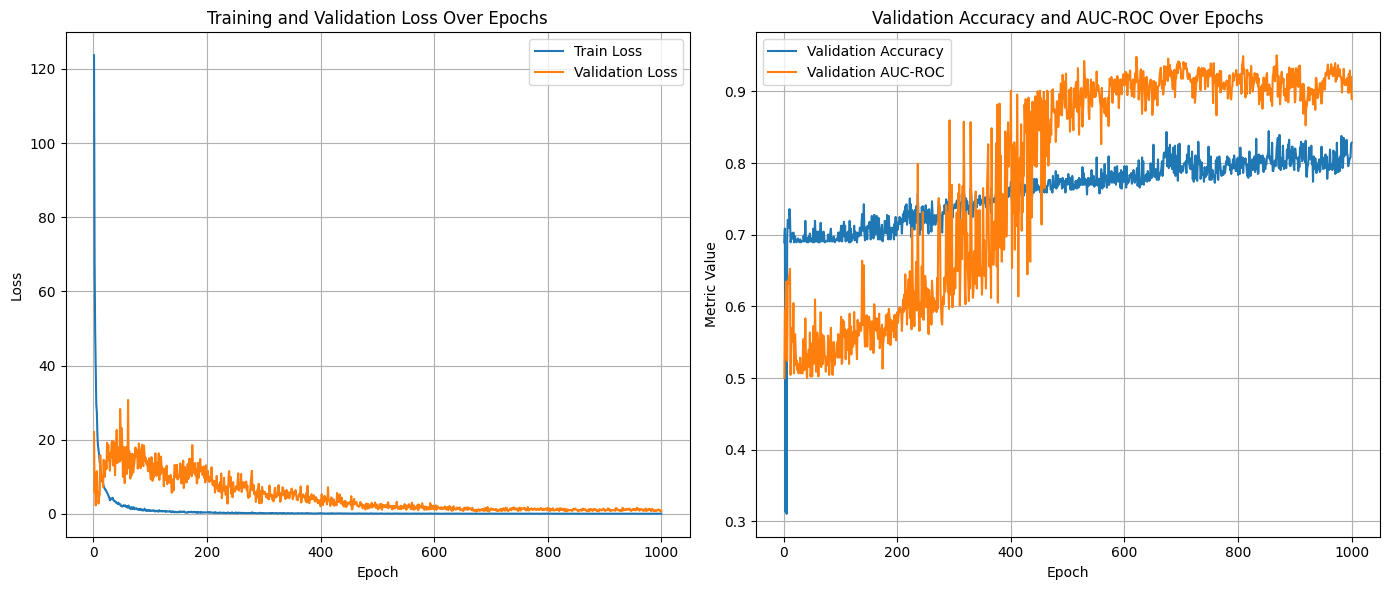

In [120]:
# Load the best model before final evaluation
model.load_state_dict(torch.load('best_link_prediction_model.pt'))
print("Loaded best model for final test evaluation.")

# Evaluation on Test Set
print("\n Evaluating on Test Set")
test_loss, test_acc, f1, precision, recall, test_auc, avg_precision, all_predictions_np, all_probs_np, all_labels_np, all_predicted_positive_global_edges = evaluate_link_prediction(model, test_loader, criterion, device,
                         neg_sample_ratio=1.0, # This will be passed as num_neg_samples_per_pos_edge
                         radius_threshold=my_radius_threshold, epoch_num=epoch)
print(f"Final Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC-ROC: {test_auc:.4f}")

# Plotting the Results
epochs_range = range(1, len(train_losses) + 1) 

plt.figure(figsize=(14, 6)) 

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy and AUC-ROC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_aucs, label='Validation AUC-ROC')
plt.title('Validation Accuracy and AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [121]:
all_predicted_positive_global_edges[0]

(374, 370, True, np.float32(0.99054724), np.float32(1.0))

In [122]:
column_names = [
    'source_global_id',
    'target_global_id',
    'is_target_t_plus_1',
    'predicted_probability',
    'true_label'
]
df_predicted_pos_edges = pd.DataFrame(all_predicted_positive_global_edges, columns=column_names)

In [123]:
df_predicted_pos_edges.head(5)

,source_global_id,target_global_id,is_target_t_plus_1,predicted_probability,true_label
0,374,370,True,0.990547,1.0
1,284,271,True,0.997881,1.0
2,472,459,True,0.999996,1.0
3,80,42,True,0.999468,1.0
4,439,434,True,0.995243,1.0


In [130]:
track_nodes_list = df_predicted_pos_edges['source_global_id'].unique()

In [124]:
def find_lineage_branches_optimized_v3(graph):
    print("--- Function find_lineage_branches_optimized_v3 started ---")
    all_lineage_segments = []

    print("Step 1: Identifying root nodes...")
    root_nodes = [node for node, in_degree in graph.in_degree() if in_degree == 0]
    print(f"Step 1 Complete: Found {len(root_nodes)} root nodes. Roots: {root_nodes[:5]}...")

    print("Step 2: Initializing stack...")
    stack = deque()
    # A set to keep track of (node, start_node_of_this_segment) pairs already processed
    # This prevents infinite loops if a node can be reached by multiple paths that don't constitute a cycle.
    processed_segments_from_node = set()

    if not root_nodes:
        print("WARNING: No root nodes found in the graph! Returning empty list.")
        return []

    for root in root_nodes:
        # Each root starts a new path segment.
        stack.append((root, [root]))
        processed_segments_from_node.add((root, root)) # Add (current_node, start_node_of_this_segment)

    print(f"Step 2 Complete: Stack initialized with {len(stack)} items.")

    print("Step 3: Entering main traversal loop...")

    iteration_count = 0
    while stack:
        iteration_count += 1
        if iteration_count % 1000 == 0:
            print(f"  Iteration {iteration_count}: Stack size: {len(stack)}")

        current_node, current_path_builder = stack.pop()
        # The 'current_path_builder' is mutable. Its first element is the start of *this* segment.
        segment_start_node = current_path_builder[0]

        # Debugging the node being processed (uncomment for verbose output)
        print(f"Processing node: {current_node}, current segment length: {len(current_path_builder)}")
        print(f"  Segment started from: {segment_start_node}")

        out_degree = graph.out_degree(current_node)

        # Case 1: Leaf Node (end of a lineage segment)
        if out_degree == 0:
            print(f"  Node {current_node} is a leaf.")
            all_lineage_segments.append({"type": "segment_to_leaf", "path": list(current_path_builder)})
            # No need to add to processed_segments_from_node here, as it's a terminal point for this branch.
            continue

        # Case 2: Division Node (more than one outgoing edge)
        if out_degree > 1:
            print(f"  Node {current_node} is a division point.")
            all_lineage_segments.append({"type": "segment_to_division", "path": list(current_path_builder)})

            # For each successor, start a NEW lineage segment.
            # Push a new path_builder list onto the stack for each branch.
            for neighbor in graph.neighbors(current_node):
                new_segment_path = [current_node, neighbor] # New segment starts from current_node
                # Only push if this (neighbor, new_segment_start) hasn't been processed
                if (neighbor, current_node) not in processed_segments_from_node:
                    stack.append((neighbor, new_segment_path))
                    processed_segments_from_node.add((neighbor, current_node))
            continue

        # Case 3: Straight Line (exactly one outgoing edge)
        if out_degree == 1:
            print(f"  Node {current_node} is a straight-line node.")
            neighbor = next(iter(graph.neighbors(current_node)))

            # If this (neighbor, segment_start_node) has already been processed, don't re-add to stack
            # This is key to stopping the redundant processing.
            if (neighbor, segment_start_node) not in processed_segments_from_node:
                current_path_builder.append(neighbor) # Append in place
                stack.append((neighbor, current_path_builder))
                processed_segments_from_node.add((neighbor, segment_start_node))
            else:
                print(f"  Skipping re-processing ({neighbor}, {segment_start_node})") # Debug print for skipped nodes

    print(f"Step 3 Complete: Main traversal loop finished after {iteration_count} iterations.")
    print(f"Total lineage segments collected: {len(all_lineage_segments)}")
    print("--- Function find_lineage_branches_optimized_v3 finished ---")
    return all_lineage_segments

In [125]:
import networkx as nx
from multiprocessing import Pool, cpu_count
import itertools
from collections import deque
import cProfile
import pstats
import io

In [126]:
G = nx.DiGraph()

G.add_edges_from(df_predicted_pos_edges[['source_global_id', 'target_global_id']].values)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 484 nodes and 419 edges.


In [ ]:
branches = find_lineage_branches_optimized_v3(G)

In [59]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id'):
    fig, ax = plt.subplots(2,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax[0].imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(fluor_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()
    #plt.savefig(fig_dir)
    #plt.close(fig)

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'
    text_color = 'white' # Color for the track ID text
    text_offset_x = 5 # Offset the text slightly from the centroid to avoid overlap
    text_offset_y = 0

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    all_text_params = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)
        
        # --- Add Track ID Text ---
        if lineage_col and pd.notna(region_props[lineage_col]):
            track_id = region_props[lineage_col]
            # Convert track_id to int if it's a float, for cleaner display
            if isinstance(track_id, float) and track_id.is_integer():
                track_id_display = int(track_id)
            else:
                track_id_display = track_id

            all_text_params.append({
                'x': x_coord + text_offset_x,
                'y': y_coord + text_offset_y,
                's': str(track_id_display),
                'color': text_color,
                'fontsize': 8,
                'ha': 'left', # horizontal alignment
                'va': 'center', # vertical alignment
                'bbox': dict(facecolor=current_color, edgecolor='none', alpha=0.6, pad=1.0) # Background box
            })

    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)
    # Plot all track ID text at once
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [65]:
branches

[{'type': 'segment_to_division', 'path': [np.int64(947)]},
 {'type': 'segment_to_leaf',
  'path': [np.int64(947), np.int64(797), np.int64(786)]},
 {'type': 'segment_to_leaf',
  'path': [np.int64(947), np.int64(938), np.int64(933)]},
 {'type': 'segment_to_leaf',
  'path': [np.int64(796), np.int64(797), np.int64(786)]},
 {'type': 'segment_to_leaf', 'path': [np.int64(791), np.int64(776)]},
 {'type': 'segment_to_division', 'path': [np.int64(713)]},
 {'type': 'segment_to_leaf', 'path': [np.int64(713), np.int64(776)]},
 {'type': 'segment_to_leaf', 'path': [np.int64(713), np.int64(691)]},
 {'type': 'segment_to_leaf', 'path': [np.int64(983), np.int64(969)]},
 {'type': 'segment_to_leaf',
  'path': [np.int64(81), np.int64(85), np.int64(22)]},
 {'type': 'segment_to_division', 'path': [np.int64(25)]},
 {'type': 'segment_to_leaf',
  'path': [np.int64(25), np.int64(85), np.int64(22)]},
 {'type': 'segment_to_leaf', 'path': [np.int64(25), np.int64(13)]},
 {'type': 'segment_to_division',
  'path': [np.

In [71]:
branches[1]['path']

[np.int64(947), np.int64(797), np.int64(786)]

In [133]:
df_view = df_cells[df_cells['node_id'].isin(track_nodes_list)].copy()

In [136]:
df_view.head(5)

,label,area,coords,centroid_y,centroid_x,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,...,intensity_max_fluor,intensity_min_fluor,time_frame,experiment_name,FOV,trench_id,track_id,ground_truth_lineage,numeric_lineage,node_id
25,26,340.0,"[[21, 786], [21, 787], [22, 785], [22, 786], [...",44.705883,787.873529,52.042282,8.597314,12487.153320,16493.0,8132.0,...,36.0,0.0,39,DUMM_giTG69_Glucose_013025,007,295,208,A.1.2.1,6,25
29,30,405.0,"[[23, 1045], [23, 1046], [23, 1047], [24, 1044...",51.686420,1047.790123,63.746273,8.434581,12575.375000,16228.0,8590.0,...,36.0,0.0,52,DUMM_giTG69_Glucose_013025,007,295,264,A.2.2.1,15,29
38,39,329.0,"[[32, 1106], [33, 1105], [33, 1106], [33, 1107...",52.887539,1107.723404,43.889538,9.731477,12663.699219,16291.0,8405.0,...,34.0,0.0,55,DUMM_giTG69_Glucose_013025,007,295,272,A.2.2.2.1,19,38
47,48,326.0,"[[41, 706], [41, 707], [42, 705], [42, 706], [...",61.128834,708.570552,44.057232,9.676444,12991.558594,17135.0,7794.0,...,20.0,0.0,35,DUMM_giTG69_Glucose_013025,007,295,187,A.1.1.2,4,47
54,55,285.0,"[[49, 627], [50, 626], [50, 627], [50, 628], [...",67.140350,628.705263,38.279549,9.608616,12410.066406,15992.0,7681.0,...,25.0,0.0,31,DUMM_giTG69_Glucose_013025,007,295,167,A.1.1.1,3,54


In [137]:
df_predicted_pos_edges[df_predicted_pos_edges['source_global_id'] == 25]

,source_global_id,target_global_id,is_target_t_plus_1,predicted_probability,true_label
539,25,13,True,0.999979,1.0
541,25,85,True,0.986566,0.0


In [139]:
false_positives_df = df_predicted_pos_edges[(df_predicted_pos_edges['predicted_probability']>0.9) & (df_predicted_pos_edges['true_label']==0)]

In [141]:
true_positives_df = df_predicted_pos_edges[(df_predicted_pos_edges['predicted_probability']>0.9) & (df_predicted_pos_edges['true_label']==1)]

In [ ]:
false_G = nx.DiGraph()

false_G.add_edges_from(false_positives_df[['source_global_id', 'target_global_id']].values)
print(f"Graph created with {false_G.number_of_nodes()} nodes and {false_G.number_of_edges()} edges.")
false_branches = find_lineage_branches_optimized_v3(false_G)


true_G = nx.DiGraph()

true_G.add_edges_from(true_positives_df[['source_global_id', 'target_global_id']].values)
print(f"Graph created with {true_G.number_of_nodes()} nodes and {true_G.number_of_edges()} edges.")
true_branches = find_lineage_branches_optimized_v3(true_G)

In [148]:
source_nodes_fp = false_positives_df['source_global_id'].unique()
target_nodes_fp = false_positives_df['target_global_id'].unique()
source_nodes_tp = true_positives_df['source_global_id'].unique()
target_nodes_tp = true_positives_df['target_global_id'].unique()

In [ ]:
#for fov 007 and trench id 371
exp_view = 'DUMM_giTG69_Glucose_013025'
fov_view = '007'
trench_view= '371'

df_view = df_cells[df_cells['node_id'].isin(source_nodes_fp) | df_cells['node_id'].isin(target_nodes_fp)].copy()

path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

for i in range(len(false_branches)):
    plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view[df_view['node_id'].isin(false_branches[i]['path'])], 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='node_id')

In [ ]:
#for fov 007 and trench id 371
exp_view = 'DUMM_giTG69_Glucose_013025'
fov_view = '007'
trench_view= '371'

df_view = df_cells[df_cells['node_id'].isin(source_nodes_tp) | df_cells['node_id'].isin(target_nodes_tp)].copy()

path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

for i in range(len(true_branches)):
    plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view[df_view['node_id'].isin(true_branches[i]['path'])], 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='node_id')

In [153]:
#Training was done on
#for fov 007 and trench id 295
#for fov 007 and trench id 371

In [164]:
df_process = df[~df['trench_id'].isin(['295', '371'])].copy()

In [162]:
from scipy.spatial import KDTree

# This is the helper function that will use KDTree for candidate generation
def generate_potential_edges_for_time_step_kdtree(df_current_t: pd.DataFrame, df_next_t: pd.DataFrame,
                                                  offset_t_plus_1_nodes: int,
                                                  proximity_threshold_1d: float,
                                                  max_neighbors: int,
                                                  device: str = 'cpu'):
    """
    Generates plausible (source, target) edge candidates between nodes in df_current_t
    and nodes in df_next_t using KDTree for spatial proximity (1D 'centroid_y').

    Args:
        df_current_t (pd.DataFrame): DataFrame for time t nodes. Must contain 'node_id' and 'centroid_y'.
        df_next_t (pd.DataFrame): DataFrame for time t+1 nodes. Must contain 'node_id' and 'centroid_y'.
        offset_t_plus_1_nodes (int): The offset to add to target node local indices
                                     to align with the concatenated node feature matrix (x_t then x_t_plus_1).
        proximity_threshold_1d (float): Maximum 1D Euclidean distance (along centroid_y)
                                        for a candidate link.
        max_neighbors (int): Limits the number of candidate edges a source cell can have
                             to cells in the next time frame.
        device (str): Device for tensors.

    Returns:
        torch.Tensor: A (2, N) tensor of local (source, target) indices for potential edges.
                      These indices are relative to the concatenated node features of this time step.
    """
    candidate_edges = []

    if df_current_t.empty or df_next_t.empty:
        return torch.empty((2, 0), dtype=torch.long, device=device)

    # Map global node IDs to local indices *within this specific t -> t+1 Data object*
    # Cells from df_current_t get indices 0 to num_cells_t - 1
    # Cells from df_next_t get indices num_cells_t to num_cells_t + num_cells_t_plus_1 - 1
    current_t_local_id_map = {node_id: idx for idx, node_id in enumerate(df_current_t['node_id'])}
    next_t_local_id_map = {node_id: idx + offset_t_plus_1_nodes for idx, node_id in enumerate(df_next_t['node_id'])}

    # Extract positions (centroid_y) for KDTree
    current_t_pos_data = df_current_t['centroid_y'].values.reshape(-1, 1) # Reshape to [N, 1] for KDTree
    next_t_pos_data = df_next_t['centroid_y'].values.reshape(-1, 1)

    if len(next_t_pos_data) == 0:
        return torch.empty((2, 0), dtype=torch.long, device=device)

    # Build KDTree for cells in the next time frame
    kdtree_next_t = KDTree(next_t_pos_data)

    # Iterate through each source node in the current time frame
    for _, row_t in df_current_t.iterrows():
        source_global_id = row_t['node_id']
        source_local_idx = current_t_local_id_map[source_global_id]
        source_node_pos = np.array([[row_t['centroid_y']]]) # Ensure 2D for query

        # Query KDTree for neighbors within radius
        # Returns a list of lists, [0] to get the list for the single query point
        neighbor_kdtree_indices_in_radius = kdtree_next_t.query_ball_point(
            source_node_pos, r=proximity_threshold_1d
        )[0]

        if not neighbor_kdtree_indices_in_radius:
            continue

        # Get actual distances for these neighbors and sort to select top K
        distances_to_in_radius_neighbors = []
        for kdtree_idx_in_next_t_pos_data in neighbor_kdtree_indices_in_radius:
            target_pos_val = next_t_pos_data[kdtree_idx_in_next_t_pos_data][0] # Get scalar value
            dist = abs(source_node_pos[0][0] - target_pos_val) # 1D distance
            distances_to_in_radius_neighbors.append((dist, kdtree_idx_in_next_t_pos_data))

        # Sort by distance and take the top `max_neighbors`
        distances_to_in_radius_neighbors.sort(key=lambda x: x[0])
        selected_neighbors_kdtree_indices = [
            item[1] for item in distances_to_in_radius_neighbors[:max_neighbors]
        ]

        # Add selected candidate edges to the list
        for next_tf_kdtree_idx in selected_neighbors_kdtree_indices:
            # Map back from KDTree index to original df_next_t index (for 'node_id')
            # The KDTree indices correspond to the row indices of df_next_t's 'centroid_y' array
            target_global_id = df_next_t.iloc[next_tf_kdtree_idx]['node_id']
            target_local_idx = next_t_local_id_map[target_global_id]
            candidate_edges.append((source_local_idx, target_local_idx))

    if not candidate_edges:
        return torch.empty((2, 0), dtype=torch.long, device=device)
    else:
        # Use a set to ensure uniqueness
        unique_edges = list(set(candidate_edges))
        # Transpose to get [2, num_edges] format
        return torch.tensor(unique_edges, dtype=torch.long).T.to(device)


def create_candidate_graph_data_objects_kdtree(df_lineage: pd.DataFrame, node_feature_cols: list,
                                            device: str = 'cpu',
                                            proximity_threshold_1d: float = None,
                                            max_neighbors: int = 2):
    """
    Generates a list of PyG Data objects, where each Data object represents a single
    time-step transition (t -> t+1) within a lineage branch. Its `edge_index`
    attribute is populated with *potential* link candidates generated using KDTree
    based on spatial proximity (centroid_y).

    Args:
        df_lineage (pd.DataFrame): DataFrame containing data for a specific lineage branch.
                                   Must include 'node_id', 'time_frame', 'centroid_y',
                                   and other node features.
        node_feature_cols (list): List of column names for node features.
        device (str): Device to put tensors on.
        proximity_threshold_1d (float, optional): Maximum 1D Euclidean distance (along centroid_y)
                                                  for a candidate link. This parameter is REQUIRED.
        max_neighbors (int, optional): Limits the number of candidate edges a cell can have
                                       to cells in the next time frame.

    Returns:
        list[Data]: A list of PyG Data objects, each representing one t -> t+1 transition
                    with candidate edges.
    """
    if proximity_threshold_1d is None:
        raise ValueError("The 'proximity_threshold_1d' must be provided for KDTree based candidate generation.")

    all_time_step_data = []

    # Get unique time frames and sort them
    sorted_time_frames = sorted(df_lineage['time_frame'].unique())

    # Iterate through consecutive time frames
    for i in range(len(sorted_time_frames) - 1):
        current_t = sorted_time_frames[i]
        next_t = sorted_time_frames[i+1]

        df_current_t = df_lineage[df_lineage['time_frame'] == current_t].copy()
        df_next_t = df_lineage[df_lineage['time_frame'] == next_t].copy()

        # Skip if no cells in either timeframe
        if df_current_t.empty or df_next_t.empty:
            print(f"  Skipping time_frame transition {current_t} -> {next_t} due to empty dataframes.")
            continue

        # Ensure required columns are present in each time-slice DataFrame for KDTree and features
        required_cols_kdtree = ['node_id', 'centroid_y']
        if not all(col in df_current_t.columns for col in required_cols_kdtree) or \
           not all(col in df_next_t.columns for col in required_cols_kdtree):
            missing_current = [col for col in required_cols_kdtree if col not in df_current_t.columns]
            missing_next = [col for col in required_cols_kdtree if col not in df_next_t.columns]
            print(f"  Skipping transition {current_t} -> {next_t}. Missing KDTree required columns: "
                  f"Current T: {missing_current}, Next T: {missing_next}")
            continue

        # Create combined node features, positions, time_frames for this specific t -> t+1 pair
        x_t = torch.tensor(df_current_t[node_feature_cols].values, dtype=torch.float).to(device)
        x_t_plus_1 = torch.tensor(df_next_t[node_feature_cols].values, dtype=torch.float).to(device)
        x = torch.cat([x_t, x_t_plus_1], dim=0)

        pos_t = torch.tensor(df_current_t['centroid_y'].values, dtype=torch.float).to(device)
        pos_t_plus_1 = torch.tensor(df_next_t['centroid_y'].values, dtype=torch.float).to(device)
        pos = torch.cat([pos_t, pos_t_plus_1], dim=0) # Concatenated positions for the Data object

        time_frames_t = torch.tensor(df_current_t['time_frame'].values, dtype=torch.long).to(device)
        time_frames_t_plus_1 = torch.tensor(df_next_t['time_frame'].values, dtype=torch.long).to(device)
        time_frame_concat = torch.cat([time_frames_t, time_frames_t_plus_1], dim=0)


        num_cells_t = len(df_current_t)
        num_cells_t_plus_1 = len(df_next_t)
        offset_t_plus_1_nodes = num_cells_t # Local index offset for t+1 nodes in the combined 'x' tensor

        # --- Generate potential edges using the KDTree helper function ---
        potential_edges_for_this_timeframe = generate_potential_edges_for_time_step_kdtree(
            df_current_t=df_current_t,
            df_next_t=df_next_t,
            offset_t_plus_1_nodes=offset_t_plus_1_nodes,
            proximity_threshold_1d=proximity_threshold_1d,
            max_neighbors=max_neighbors,
            device=device
        )

        if potential_edges_for_this_timeframe.numel() == 0:
            print(f"  No potential edges generated for time_frame transition {current_t} -> {next_t} with given parameters. Skipping Data object creation.")
            continue

        # Create and append the Data object for this time step
        data = Data(
            x=x,
            edge_index=potential_edges_for_this_timeframe, # This now contains the potential links
            pos=pos, # All concatenated positions for cells in this timeframe (t then t+1)
            time_frame=time_frame_concat, # All time frames for cells in this timeframe (t then t+1)
            num_nodes=len(x), # Total nodes in this specific Data object
            # Attributes required for models that handle time steps / bipartite graphs
            num_nodes_t=num_cells_t,
            num_nodes_t_plus_1=num_cells_t_plus_1,
            offset_t_plus_1_nodes=offset_t_plus_1_nodes,
            # Pass original global IDs for mapping back after prediction
            original_global_node_ids_t=torch.tensor(df_current_t['node_id'].values, dtype=torch.long),
            original_global_node_ids_t_plus_1=torch.tensor(df_next_t['node_id'].values, dtype=torch.long),
            # Keep original metadata if useful for grouping/filtering later
            experiment_name=df_lineage['experiment_name'].iloc[0] if 'experiment_name' in df_lineage.columns else 'N/A',
            fov=df_lineage['FOV'].iloc[0] if 'FOV' in df_lineage.columns else 'N/A',
            trench_id=df_lineage['trench_id'].iloc[0] if 'trench_id' in df_lineage.columns else 'N/A',
        )
        all_time_step_data.append(data)

    return all_time_step_data

In [169]:
FOV = '007'
trench_id = ['295', '371']
df_process = all_cells_pd[~all_cells_pd['trench_id'].isin(trench_id)].copy()


df_process.rename(columns = {'centroid-0': 'centroid_y','centroid-1': 'centroid_x'}, inplace = True)

# Define node features
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']

for col in node_feature_cols:
    df_process.loc[:, col] = df_process.loc[:,col].astype(np.float32);               

df_process.loc[:,'node_id'] = df_process.index # Assign unique global node ID

In [171]:
df_process.columns

Index(['label', 'area', 'coords', 'centroid_y', 'centroid_x',
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor', 'time_frame',
       'experiment_name', 'FOV', 'trench_id', 'track_id', 'node_id'],
      dtype='object')

In [175]:
print("Creating candidate graphs for prediction...")
prediction_data_list = []
sub_lineage_roots_tuples_new_data = lineage.identify_exp_fov(df_process)

for exp, fov, trench, root_lineage_string in sub_lineage_roots_tuples_new_data:
    df_branch = df_process[
        (df_process['experiment_name'] == exp) &
        (df_process['FOV'] == fov) &
        (df_process['trench_id'] == trench) 
        # Note: No ground_truth_lineage filtering here, as we're predicting new data
    ].copy()

    if not df_branch.empty:
        # Use your KDTree-based function to create Data objects with potential edges
        time_step_data_list_for_branch = create_candidate_graph_data_objects_kdtree(
            df_branch,
            node_feature_cols,
            device,
            proximity_threshold_1d=50, 
            max_neighbors=5
        )
        prediction_data_list.extend(time_step_data_list_for_branch)

print(f"Finished creating {len(prediction_data_list)} Data objects for prediction.")

Creating candidate graphs for prediction...
Finished creating 303 Data objects for prediction.


In [176]:
print("Applying feature scaling transform to Data objects...")
prediction_data_list_scaled = []
for data_obj in prediction_data_list:
    scaled_data_obj = feature_scaler_transform(data_obj) # Apply the transform
    prediction_data_list_scaled.append(scaled_data_obj)
print("Feature scaling complete.")

Applying feature scaling transform to Data objects...
Feature scaling complete.


In [177]:
batch_size = 32

prediction_loader = DataLoader(prediction_data_list_scaled, batch_size=batch_size, shuffle=False)
print(f"\nPrediction DataLoader created successfully with {len(prediction_loader)} batches.")


Prediction DataLoader created successfully with 10 batches.


In [178]:
def predict_link_probabilities(model, loader, device,
                                 radius_threshold=None, epoch_num=None,
                                 num_link_candidates_per_node=None):
    """
    Predicts link probabilities for all candidate edges in the provided DataLoader.

    Args:
        model (torch.nn.Module): The trained GNN model.
        loader (torch_geometric.loader.DataLoader): DataLoader containing Data objects
                                                     with candidate edges.
        device (str): Device (e.g., 'cpu' or 'cuda') to perform computations on.
        radius_threshold (float, optional): Not used in this function, kept for signature consistency.
        epoch_num (int, optional): Optional epoch number for logging.
        num_link_candidates_per_node (int, optional): Not used in this function, kept for consistency.

    Returns:
        list: A list of tuples, where each tuple contains:
              (source_global_id, target_global_id, is_target_t_plus_1, predicted_probability)
              for each candidate edge.
    """
    model.eval() # Set model to evaluation mode
    all_predicted_info = [] # To store (src_global_id, tgt_global_id, is_t_plus_1, prob)

    num_batches_processed = 0

    print(f"\n--- Starting Link Probability Prediction for Epoch {epoch_num if epoch_num is not None else 'N/A'} (Batch-by-Batch) ---")

    with torch.no_grad(): # Disable gradient calculations for inference
        for i, data in enumerate(loader):
            data = data.to(device)

            # Essential attributes check (similar to your evaluation function)
            required_attrs = ['original_global_node_ids_t', 'original_global_node_ids_t_plus_1',
                              'num_nodes_t', 'num_nodes_t_plus_1', 'offset_t_plus_1_nodes', 'ptr',
                              'pos', 'time_frame']
            if not all(hasattr(data, attr) for attr in required_attrs):
                print(f"  Skipping batch {i+1} due to missing essential attributes: {', '.join([attr for attr in required_attrs if not hasattr(data, attr)])}")
                continue

            # Your `data.edge_index` already contains the candidate edges from `create_candidate_graph_data_objects_kdtree`
            all_candidate_edges_local = data.edge_index

            if all_candidate_edges_local is None or all_candidate_edges_local.numel() == 0:
                print(f"  Skipping prediction batch {i+1}: No candidate edges in Data object.")
                continue

            # Ensure edge_index is long type
            if all_candidate_edges_local.dtype != torch.long:
                all_candidate_edges_local = all_candidate_edges_local.long()

            # --- Model Forward Pass ---
            z = model(data.x, all_candidate_edges_local) # Get node embeddings
            logits = model.decode(z, all_candidate_edges_local) # Get raw logits for candidate edges
            probabilities = torch.sigmoid(logits) # Convert logits to probabilities

            num_batches_processed += 1

            # --- Extract Global IDs and Probabilities for each edge in the batch ---
            num_graphs_in_batch = len(data.ptr) - 1

            current_batch_cum_t_nodes = 0
            current_batch_cum_t_plus_1_nodes = 0

            # Loop through each individual graph within the current batch
            for graph_idx_in_batch in range(num_graphs_in_batch):
                start_node_idx_in_batch = data.ptr[graph_idx_in_batch].item()
                end_node_idx_in_batch = data.ptr[graph_idx_in_batch + 1].item()

                # Slice the original global IDs for the current graph
                start_t_slice_in_batch = current_batch_cum_t_nodes
                end_t_slice_in_batch = current_batch_cum_t_nodes + data.num_nodes_t[graph_idx_in_batch].item()
                graph_original_ids_t = data.original_global_node_ids_t[start_t_slice_in_batch:end_t_slice_in_batch]

                start_t_plus_1_slice_in_batch = current_batch_cum_t_plus_1_nodes
                end_t_plus_1_slice_in_batch = current_batch_cum_t_plus_1_nodes + data.num_nodes_t_plus_1[graph_idx_in_batch].item()
                graph_original_ids_t_plus_1 = data.original_global_node_ids_t_plus_1[start_t_plus_1_slice_in_batch:end_t_plus_1_slice_in_batch]

                graph_offset_t_plus_1_nodes = data.offset_t_plus_1_nodes[graph_idx_in_batch].item()

                # Filter `all_candidate_edges_local` to only include edges belonging to the current graph
                graph_candidate_edge_mask = (all_candidate_edges_local[0] >= start_node_idx_in_batch) & \
                                            (all_candidate_edges_local[0] < end_node_idx_in_batch) & \
                                            (all_candidate_edges_local[1] >= start_node_idx_in_batch) & \
                                            (all_candidate_edges_local[1] < end_node_idx_in_batch)

                graph_edges_local_filtered = all_candidate_edges_local[:, graph_candidate_edge_mask]
                graph_probs_slice = probabilities[graph_candidate_edge_mask].tolist()

                if graph_edges_local_filtered.numel() == 0:
                    # Update cumulative node counts for the next graph in this batch
                    current_batch_cum_t_nodes += data.num_nodes_t[graph_idx_in_batch].item()
                    current_batch_cum_t_plus_1_nodes += data.num_nodes_t_plus_1[graph_idx_in_batch].item()
                    continue

                # Create a combined mapping from batch-local node index to global ID for this graph's nodes
                global_id_map_for_graph_nodes = torch.cat([graph_original_ids_t, graph_original_ids_t_plus_1])

                # Convert local edge indices to global node IDs
                source_global_ids = global_id_map_for_graph_nodes[graph_edges_local_filtered[0] - start_node_idx_in_batch]
                target_global_ids = global_id_map_for_graph_nodes[graph_edges_local_filtered[1] - start_node_idx_in_batch]

                # Determine if the target node is from t+1 based on its local index relative to the offset
                is_target_t_plus_1 = (graph_edges_local_filtered[1] - start_node_idx_in_batch) >= graph_offset_t_plus_1_nodes

                # Collect results
                for k in range(graph_edges_local_filtered.size(1)):
                    prob = graph_probs_slice[k] # Already a scalar from .tolist()

                    all_predicted_info.append((
                        source_global_ids[k].item(), # Convert tensor to Python scalar
                        target_global_ids[k].item(),
                        is_target_t_plus_1[k].item(), # Convert boolean tensor to Python boolean
                        prob
                    ))

                # Update current_batch_cum_t_nodes and current_batch_cum_t_plus_1_nodes for the next graph in this batch
                current_batch_cum_t_nodes += data.num_nodes_t[graph_idx_in_batch].item()
                current_batch_cum_t_plus_1_nodes += data.num_nodes_t_plus_1[graph_idx_in_batch].item()

    print(f"\n--- Finished Link Probability Prediction for Epoch {epoch_num if epoch_num is not None else 'N/A'} ---")
    if num_batches_processed == 0:
        print("Warning: No batches were processed for prediction. Returning empty list.")
        return []

    return all_predicted_info


In [179]:
# 7. Predict link probabilities using the new function
print("\nStarting link probability prediction on scaled data...")
predicted_links_info = predict_link_probabilities(
    model=model,
    loader=prediction_loader, # This is your DataLoader with scaled features
    device=device
    # No need to pass radius_threshold or num_link_candidates_per_node if they're not used internally
)


Starting link probability prediction on scaled data...

--- Starting Link Probability Prediction for Epoch N/A (Batch-by-Batch) ---

--- Finished Link Probability Prediction for Epoch N/A ---


In [181]:
column_names = [
    'source_global_id',
    'target_global_id',
    'is_target_t_plus_1',
    'predicted_probability',
]
processed_df_predicted_edges = pd.DataFrame(predicted_links_info, columns=column_names)

In [182]:
predicted_G = nx.DiGraph()

predicted_G.add_edges_from(processed_df_predicted_edges[['source_global_id', 'target_global_id']].values)
print(f"Graph created with {predicted_G.number_of_nodes()} nodes and {predicted_G.number_of_edges()} edges.")
predicted_branches = find_lineage_branches_optimized_v3(predicted_G)

Graph created with 1816 nodes and 3781 edges.
--- Function find_lineage_branches_optimized_v3 started ---
Step 1: Identifying root nodes...
Step 1 Complete: Found 38 root nodes. Roots: [np.int64(1581), np.int64(1422), np.int64(1499), np.int64(1187), np.int64(1505)]...
Step 2: Initializing stack...
Step 2 Complete: Stack initialized with 38 items.
Step 3: Entering main traversal loop...
Processing node: 2744, current segment length: 1
  Segment started from: 2744
  Node 2744 is a straight-line node.
Processing node: 2648, current segment length: 2
  Segment started from: 2744
  Node 2648 is a division point.
Processing node: 2634, current segment length: 2
  Segment started from: 2648
  Node 2634 is a division point.
Processing node: 2620, current segment length: 2
  Segment started from: 2634
  Node 2620 is a division point.
Processing node: 2599, current segment length: 2
  Segment started from: 2620
  Node 2599 is a division point.
Processing node: 2574, current segment length: 2
  S

In [187]:
predicted_branches['path']

[{'type': 'segment_to_division', 'path': [np.int64(2744), np.int64(2648)]},
 {'type': 'segment_to_division', 'path': [np.int64(2648), np.int64(2634)]},
 {'type': 'segment_to_division', 'path': [np.int64(2634), np.int64(2620)]},
 {'type': 'segment_to_division', 'path': [np.int64(2620), np.int64(2599)]},
 {'type': 'segment_to_division', 'path': [np.int64(2599), np.int64(2574)]},
 {'type': 'segment_to_division', 'path': [np.int64(2574), np.int64(2550)]},
 {'type': 'segment_to_division', 'path': [np.int64(2550), np.int64(2532)]},
 {'type': 'segment_to_division', 'path': [np.int64(2532), np.int64(2509)]},
 {'type': 'segment_to_division', 'path': [np.int64(2509), np.int64(2489)]},
 {'type': 'segment_to_division', 'path': [np.int64(2489), np.int64(2459)]},
 {'type': 'segment_to_division',
  'path': [np.int64(2459), np.int64(2423), np.int64(2386)]},
 {'type': 'segment_to_division', 'path': [np.int64(2386), np.int64(2353)]},
 {'type': 'segment_to_division', 'path': [np.int64(2353), np.int64(233

In [189]:
longest_path_dict = None
max_path_length = -1 # Initialize with a value smaller than any possible path length

# Iterate through each dictionary in the list
for d in predicted_branches:
    # Check if 'path' key exists and its value is a list
    if 'path' in d and isinstance(d['path'], list):
        current_path_length = len(d['path'])
        # If the current path is longer, update our tracking variables
        if current_path_length > max_path_length:
            max_path_length = current_path_length
            longest_path_dict = d

print(longest_path_dict)

{'type': 'segment_to_division', 'path': [np.int64(1393), np.int64(1376), np.int64(1290), np.int64(1269), np.int64(1262), np.int64(1229), np.int64(1226), np.int64(1172), np.int64(1144)]}


In [191]:
longest_path_dict['path']

[np.int64(1393),
 np.int64(1376),
 np.int64(1290),
 np.int64(1269),
 np.int64(1262),
 np.int64(1229),
 np.int64(1226),
 np.int64(1172),
 np.int64(1144)]

In [193]:
df_process[df_process['node_id'].isin(longest_path_dict['path'])].head(5)

,label,area,coords,centroid_y,centroid_x,axis_major_length,axis_minor_length,intensity_mean_phase,intensity_max_phase,intensity_min_phase,intensity_mean_fluor,intensity_max_fluor,intensity_min_fluor,time_frame,experiment_name,FOV,trench_id,track_id,node_id
1144,48,638.0,"[[48, 607], [48, 608], [49, 605], [49, 606], [...",95.868340,608.108150,119.351013,8.247746,10906.025391,15372.0,7978.0,11.537618,39.0,0.0,30,DUMM_giTG69_Glucose_013025,007,521,85.0,1144
1172,76,358.0,"[[61, 586], [61, 587], [61, 588], [61, 589], [...",84.044693,588.377095,53.164455,8.765989,11352.609375,14707.0,7881.0,11.854749,33.0,0.0,29,DUMM_giTG69_Glucose_013025,007,521,78.0,1172
1226,130,171.0,"[[114, 569], [115, 568], [115, 569], [116, 568...",130.959061,568.315789,32.601490,6.896895,9512.596680,11473.0,7723.0,12.380117,30.0,0.0,28,DUMM_giTG69_Glucose_013025,007,521,81.0,1226
1229,133,208.0,"[[116, 548], [117, 548], [118, 548], [119, 547...",137.846161,547.990385,39.116596,7.014550,9038.086914,11377.0,7427.0,15.653846,33.0,0.0,27,DUMM_giTG69_Glucose_013025,007,521,79.0,1229
1262,166,218.0,"[[139, 527], [139, 528], [139, 529], [140, 527...",160.114685,528.311927,44.074562,6.442103,9455.568359,11400.0,7920.0,24.114679,48.0,0.0,26,DUMM_giTG69_Glucose_013025,007,521,76.0,1262


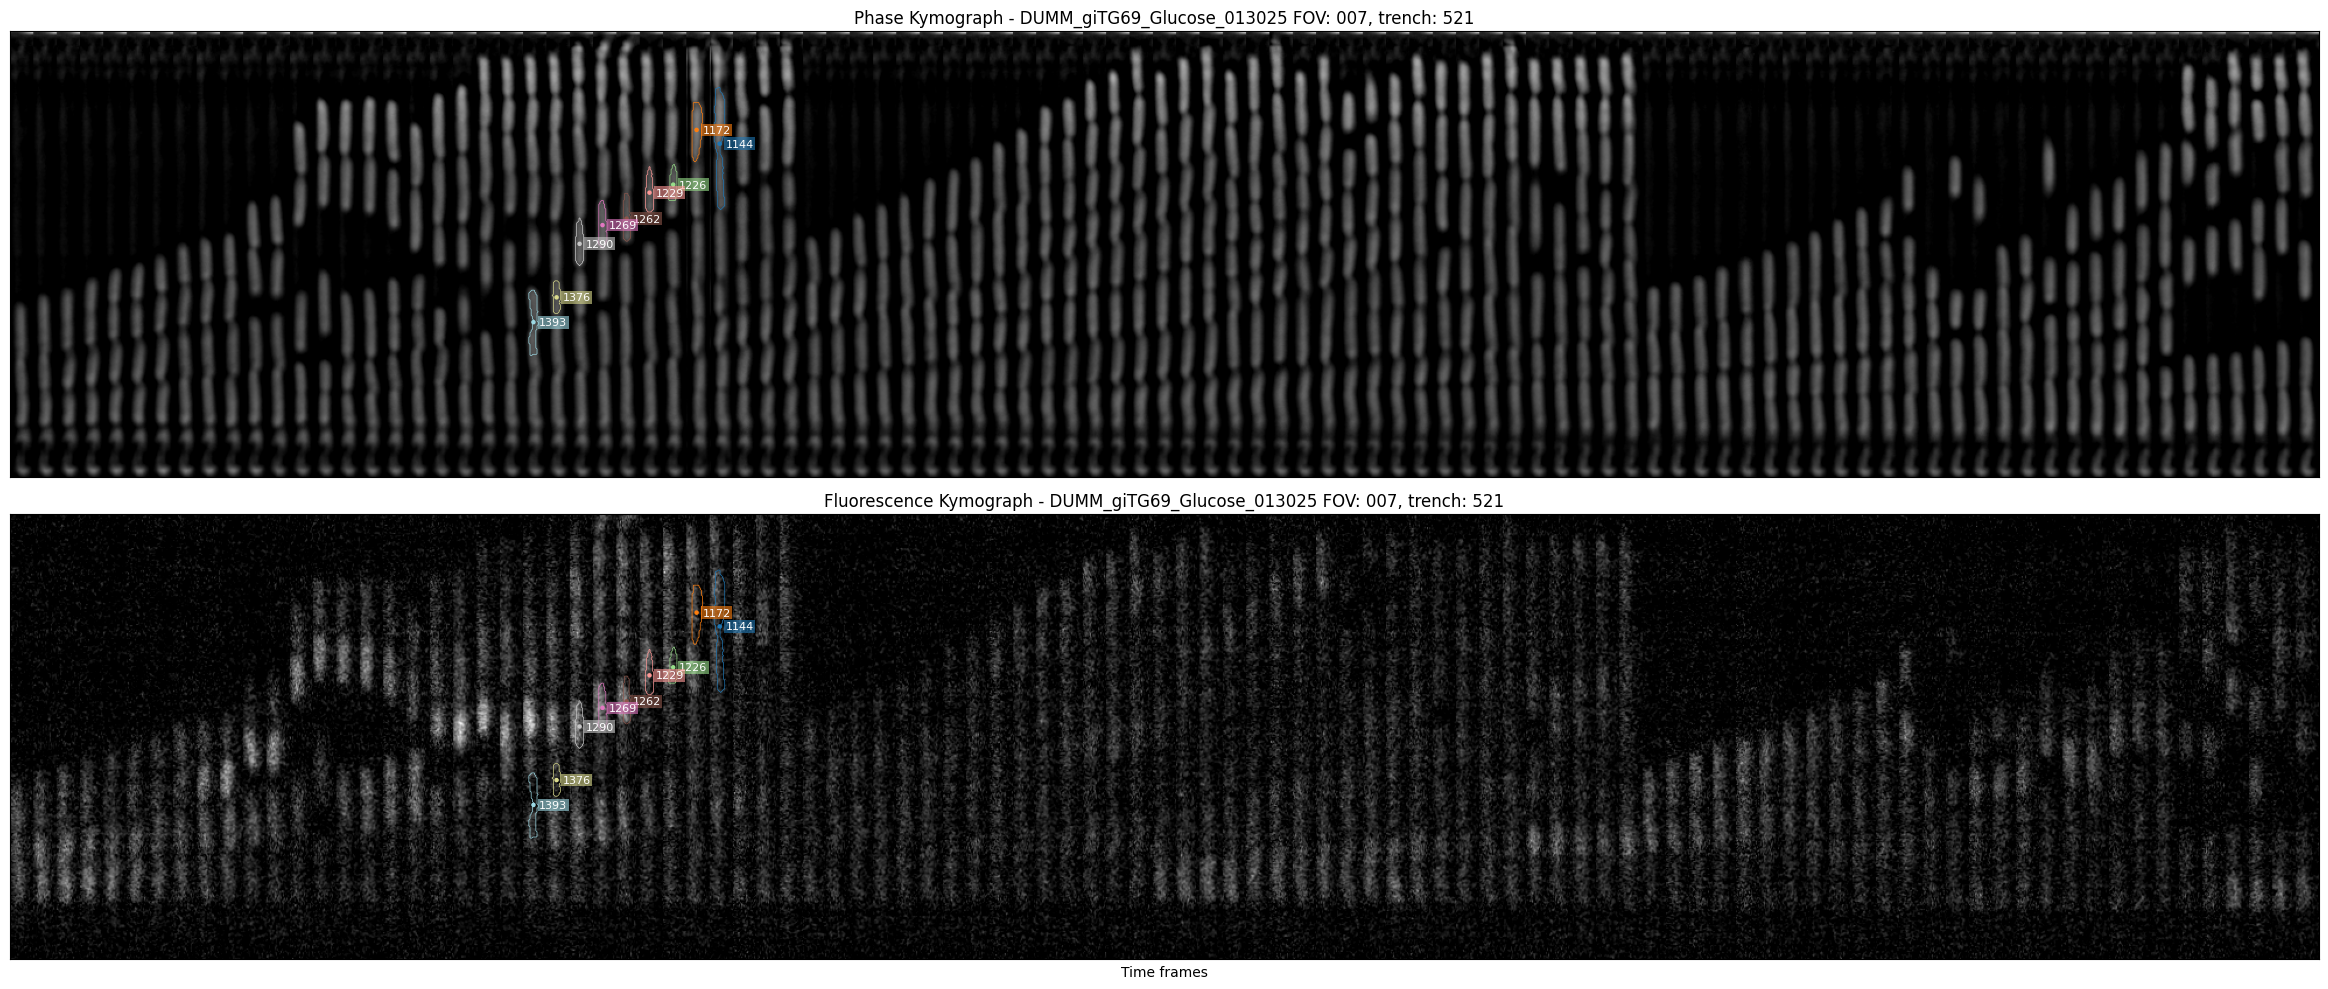

In [194]:
source_nodes = processed_df_predicted_edges['source_global_id'].unique()
target_nodes = processed_df_predicted_edges['target_global_id'].unique()
#for fov 007 and trench id 521
exp_view = 'DUMM_giTG69_Glucose_013025'
fov_view = '007'
trench_view= '521'

df_view = df_process[df_process['node_id'].isin(longest_path_dict['path'])].copy()

path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view[df_view['node_id'].isin(longest_path_dict['path'])], 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='node_id')